# Exploring the data

In [1]:
import random
import re
from pathlib import Path
from typing import Mapping, Sequence

from IPython.display import display
import matplotlib.pyplot as plt
import music21
import numpy as np
import pandas as pd
import seaborn as sns

from plotting import countplot_with_numbers, barplot_with_numbers

In [2]:
filename = "DoubleJig0001-0365.abc"
data_url = f"http://www.norbeck.nu/abc/book/oneills/1001/{filename}"
data_path = Path("..", "data")
file_path = Path(data_path, filename)

In [3]:
assert file_path.exists(), (
    "Download {filename} and put it in the data_path. You can go to the home dir and "
    "execute: wget {data_url} -P data/"
)

# Raw data

The file is just a text file containing the data and metadata

In [4]:
! head -58 {str(file_path)}
! echo ...

% These tunes are from "The Dance Music of Ireland", published by Francis O'Neill in 1907.
% They were originally transcribed in ABC format by Frank Nordberg (frnordbe@online.no) and
% hosted at his site www.musicaviva.com
% That site is down since July 2019, so the tunes were fetched from John Chambers' mirror
% at http://trillian.mit.edu/~jc/music/book/oneills/1001/ where he had also corrected some errors.
% Henrik Norbeck has then proofread the ABC format tunes against the original book and corrected
% more errors. Henrik Norbeck has also made the following changes:
% - removed all m: fields (non-standard ABC and is not in the original book)
% - replaced "  ~"N by ~ to stick closer to the original book and the ABC standard.
% - changed W to S (for Segno) to adhere to the ABC standard.
% - removed two comments which were not part of the original book
% - changed transcription comments using % to W: for consistency
% - removed C:anon. which is true for most tunes, but not for others
%

## Music21

The package [music21](http://web.mit.edu/music21/doc/) can read the whole lot into a container class.

In [5]:
# This is a class containing all the separate jigs
oneills_opus = music21.converter.parse(str(file_path.resolve()))

In [6]:
# contains 365 scores as expected
len(list(oneills_opus.scores))

365

In [7]:
# All scores have a single part
sum(len(list(score.parts.stream())) for score in oneills_opus.scores)

365

## A random jig

In [8]:
random.seed(1337)
score = random.choice(oneills_opus.scores)

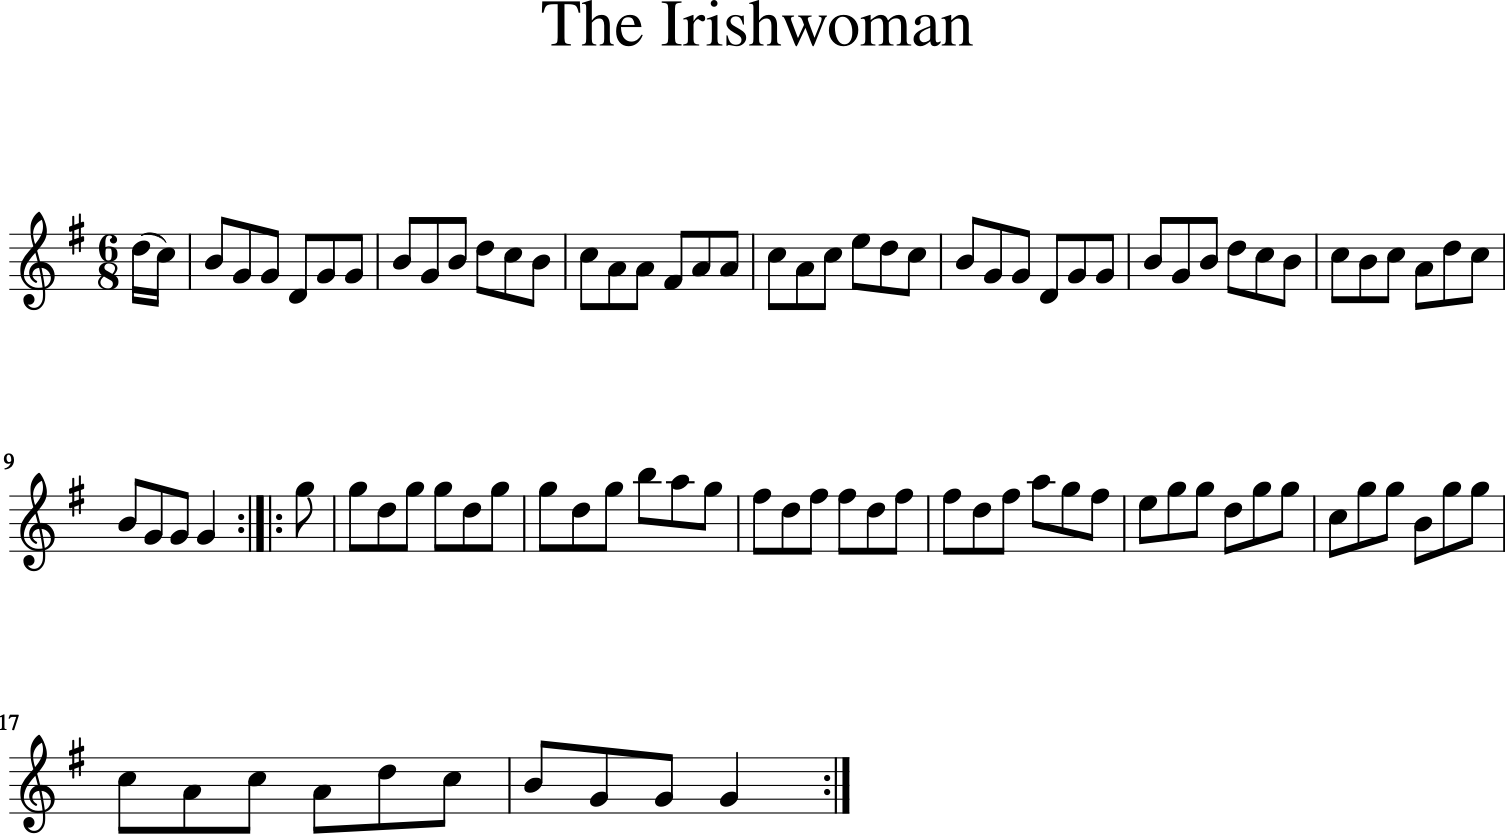

In [9]:
score.show()

## The Piper's Picnic

In [10]:
# You can select by title
score = oneills_opus.getScoreByTitle("The piper's picnic")

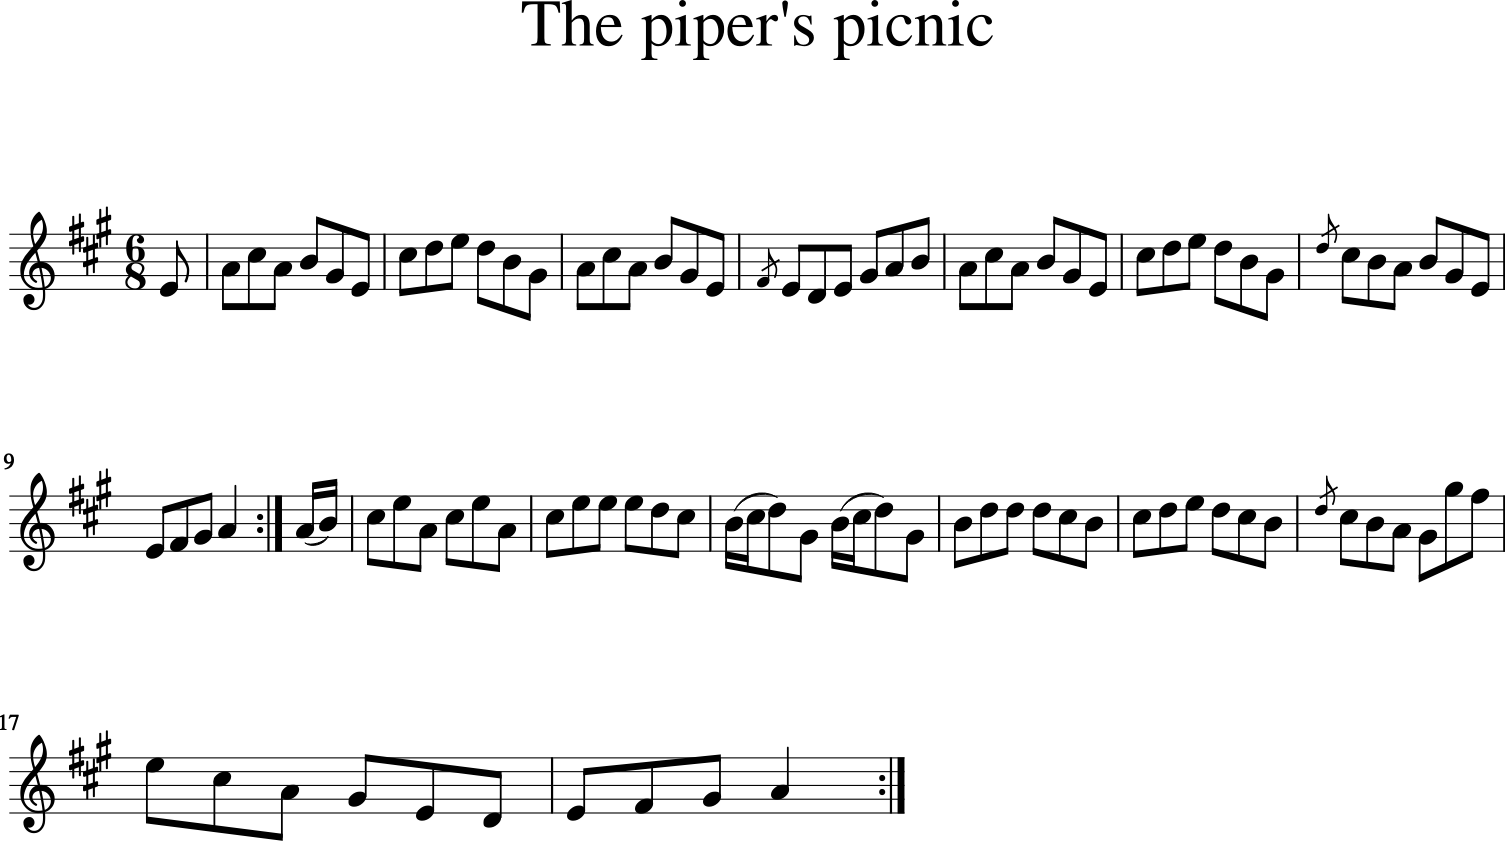

In [11]:
score.show()

Internally, music21 is storing the data as a stream of information:
* Parts contain
    * Measures which contain
        * Notes
        * and other stuff

In [12]:
score.show('text')

{0.0} <music21.metadata.Metadata object at 0x7fa8596f0a60>
{0.0} <music21.stream.Part 0x7fa8596f0bb0>
    {0.0} <music21.stream.Measure 0 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of A major>
        {0.0} <music21.meter.TimeSignature 6/8>
        {0.0} <music21.note.Note E>
    {0.5} <music21.stream.Measure 1 offset=0.5>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note C#>
        {1.0} <music21.note.Note A>
        {1.5} <music21.note.Note B>
        {2.0} <music21.note.Note G#>
        {2.5} <music21.note.Note E>
    {3.5} <music21.stream.Measure 2 offset=3.5>
        {0.0} <music21.note.Note C#>
        {0.5} <music21.note.Note D>
        {1.0} <music21.note.Note E>
        {1.5} <music21.note.Note D>
        {2.0} <music21.note.Note B>
        {2.5} <music21.note.Note G#>
    {6.5} <music21.stream.Measure 3 offset=6.5>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note C#>
        {1.0} <music21.note.No

## Extracting metadata

Here's what The Piper's Picnic looks like in the raw dataset

```
X:2
T:The piper's picnic
O:Ireland
B:Francis O'Neill: "The Dance Music of Ireland" (1907) no. 2
R:Double jig
Z:Transcribed by Frank Nordberg - http://www.musicaviva.com
F:http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0002.abc
M:6/8
L:1/8
K:A
E|AcA BGE|cde dBG|\
AcA BGE|{F}EDE GAB|AcA BGE|cde dBG|{d}cBA BGE|EFG A2:|
(A/B/)|ceA ceA|cee edc|(B/c/d)G (B/c/d)G|Bdd dcB|\
cde dcB|{d}cBA Ggf|ecA GED|EFGA2:|
```

We can get (most of) that data using music21

In [13]:
meta = score.metadata
# there is only one part to each jig so index 0 works
first_measure = score.parts[0].measure(0)
second_measure = score.parts[0].measure(1)

In [14]:
# for attr_name in meta.searchAttributes:
#     print(f"{attr_name}: {getattr(meta, attr_name)}")

('2',
 "The piper's picnic",
 'Ireland',
 None,
 None,
 None,
 None,
 '<music21.meter.TimeSignature 6/8>',
 0.5,
 'A major',
 None)

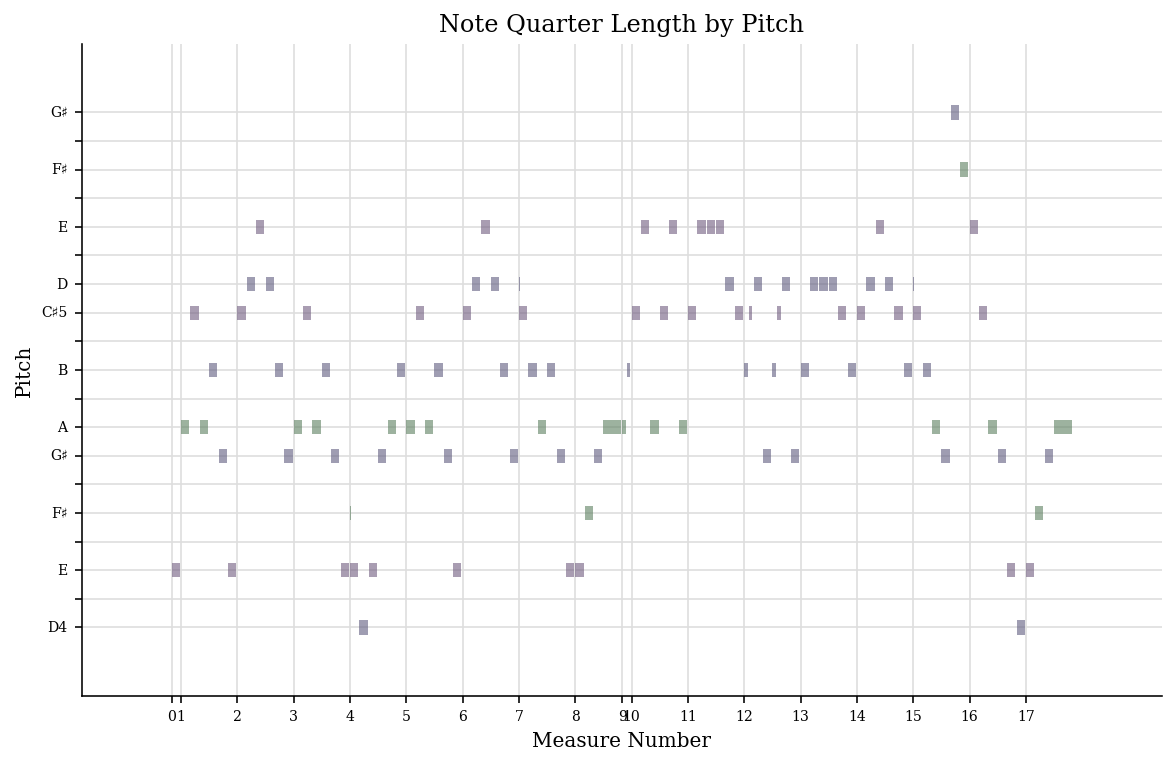

In [15]:
(
    meta.number,  # X:2
    meta.title,  # T:The piper's picnic
    meta.localeOfComposition,  # O:Ireland
    None,  # B:Francis O'Neill: "The Dance Music of Ireland" (1907) no. 2
    None,  # R:Double jig
    None,  # Z:Transcribed by Frank Nordberg - http://www.musicaviva.com
    None,  # F:http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0002.abc
    str(first_measure.timeSignature),  # M:6/8
    second_measure.offset,  # L:1/8
    str(first_measure.keySignature), # K:A
    score.plot(),  # E|AcA BGE|cde dBG|\
           # AcA BGE|{F}EDE GAB|AcA BGE|cde dBG|{d}cBA BGE|EFG A2:|
           # (A/B/)|ceA ceA|cee edc|(B/c/d)G (B/c/d)G|Bdd dcB|\
           # cde dcB|{d}cBA Ggf|ecA GED|EFGA2:|
)

# DQA

In [16]:
with open(file_path, 'r') as fh:
    # remove comments
    data_lines = [line for line in fh.readlines() if not line.startswith("%")]
    # remove leading and trailing whitespace and recombine
    data = "".join(data_lines).strip()

In [17]:
abc_strings = data.split("\n\n\n\n")

In [18]:
len(abc_strings)  # this should be 365

365

In [19]:
# Taken from: http://abcnotation.com/wiki/abc:standard:v2.1
ABC_FIELDS = {
    'A': 'area',
    'B': 'book',
    'C': 'composer',
    'D': 'discography',
    'F': 'file url',
    'G': 'group',
    'H': 'history',
    'I': 'instruction',
    'K': 'key',
    'L': 'unit note length',
    'M': 'meter',
    'm': 'macro',
    'N': 'notes',
    'O': 'origin',
    'P': 'parts',
    'Q': 'tempo',
    'R': 'rhythm',
    'r': 'remark',
    'S': 'source',
    's': 'symbol line',
    'T': 'tune title',
    'U': 'user defined',
    'V': 'voice',
    'W': 'words',
    'w': 'words',
    'X': 'reference number',
    'Z': 'transcription'
}


def merge_continuation_lines(lines: Sequence[str]) -> Sequence[str]:
    """Merges lines which end with \ with the next line.
    
    Args:
        lines: a list of strings to check and merge.
        
    Returns:
        lines: the list of strings which have been merged.
    """
    nr_checks = len(lines)
    idx = 0
    for _ in range(nr_checks):
        line = lines[idx]
        if line.endswith("\\"):
            line = line[:-1]  # remove trailing backslash
            try:
                lines[idx] = f"{line} {lines[idx+1]}"
                del lines[idx+1]  # del and stay on this line
            except IndexError as e:
                print(lines, line)
                raise e
        else:
            idx += 1
    return lines


def parse_abc(abc_str: str) -> Mapping[str, str]:
    """Get the required information from each tune.
    
    Extracts the metadata as defined in [1] from the string, plus the transcription
    which is assumed not to have a prefix. Assumes all metadata is stated before the
    transcription is started. Then adds everything remaining to the transcription.
    
    Args:
        abc_str: the string containing an abc file to parse.
        
    Returns:
        out_dict: a dictionary containing all the extracted values.
    
    See also:
    * http://abcnotation.com/wiki/abc:standard:v2.1
    """
    lines = [line.strip() for line in abc_str.split("\n")]
    
    # if a line ends with \ then merge with subsequent line
    lines = merge_continuation_lines(lines)
    
    valid_field = "|".join(ABC_FIELDS)
    metadata_line_regex = re.compile(f"^({valid_field}):")
     
    _, metadata_end_idx = min(
        (val, idx)
        for (idx, val)
        in enumerate([bool(metadata_line_regex.match(line)) for line in lines])
    )
    
    out_dict = {}
    for line in lines[:metadata_end_idx]:
        meta_key, value = line.split(":", 1)
        field_name = ABC_FIELDS[meta_key]
        if field_name in out_dict:
            concat_fields = ("tune title", "words")
            if field_name not in concat_fields:
                msg = (
                    f"Tried to add {(field_name, value)} to {out_dict}."
                    f"\nLines: {lines}"
                )
                raise ValueError(msg)
            else:
                out_dict[field_name] = f"{out_dict[field_name]} --- {line}"
        out_dict[field_name] = value
    
    transcription_label = "tune"
    for line in lines[metadata_end_idx:]:
        if line.upper().startswith("W:"):
            if "words" not in out_dict:
                out_dict["words"] = line
            else:
                out_dict["words"] = f"{out_dict['words']} --- {line}"
        elif transcription_label not in out_dict:
            out_dict[transcription_label] = line
        else:
            out_dict[transcription_label] = f"{out_dict[transcription_label]} {line}"
    return out_dict

In [20]:
parsed_abc = [parse_abc(abc) for abc in abc_strings]

In [21]:
oneills_df = pd.DataFrame(parsed_abc)

### How much of the data is missing?

In [22]:
missing_counts = oneills_df.isna().sum().rename("count_of_missing_values")
missing_counts

reference number      0
tune title            0
origin                0
book                  0
rhythm                0
transcription         0
file url              0
meter                 0
unit note length      0
key                   0
tune                  0
words               357
Name: count_of_missing_values, dtype: int64

In [23]:
id_vars = ["reference number"]
value_vars = [col for col in oneills_df.columns if col not in id_vars]
melt_df = oneills_df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name="field_name",
)
missing_df = melt_df
missing_df["value"] = missing_df["value"].isna()

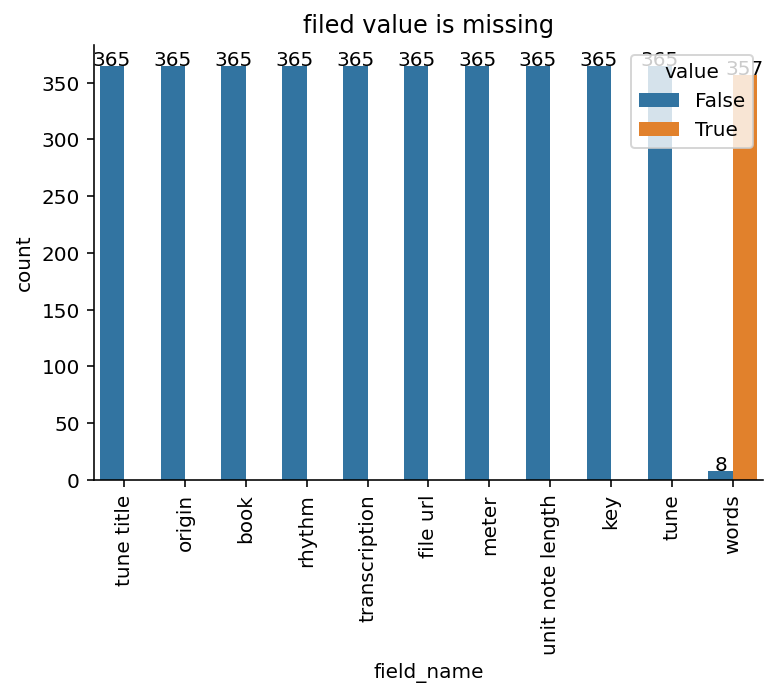

In [24]:
countplot_with_numbers(
    var_name="field_name", data=missing_df,  hue="value", kind="count"
)
plt.title("filed value is missing")
plt.xticks(rotation=90);

In [25]:
def ordered_countplot(series, **kwargs):
    count = series.value_counts()
    barplot_with_numbers(count, **kwargs)

### Vaule counts

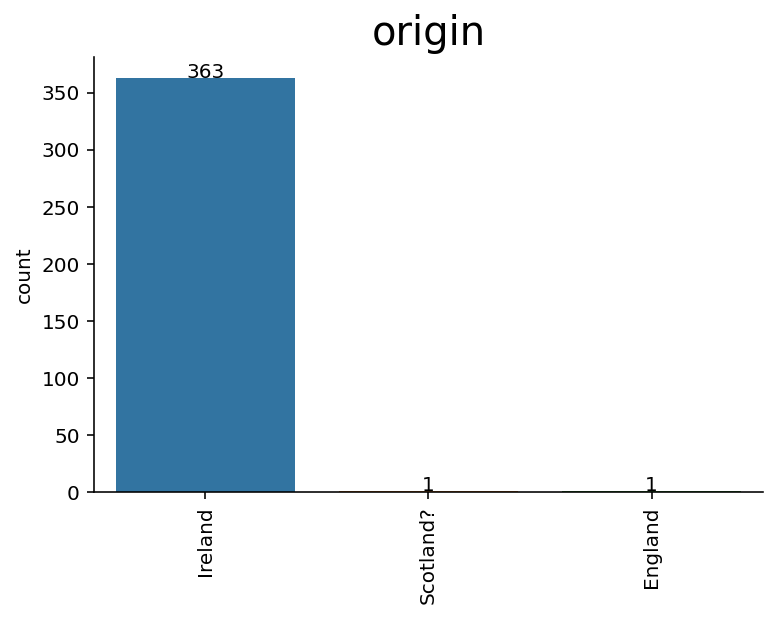

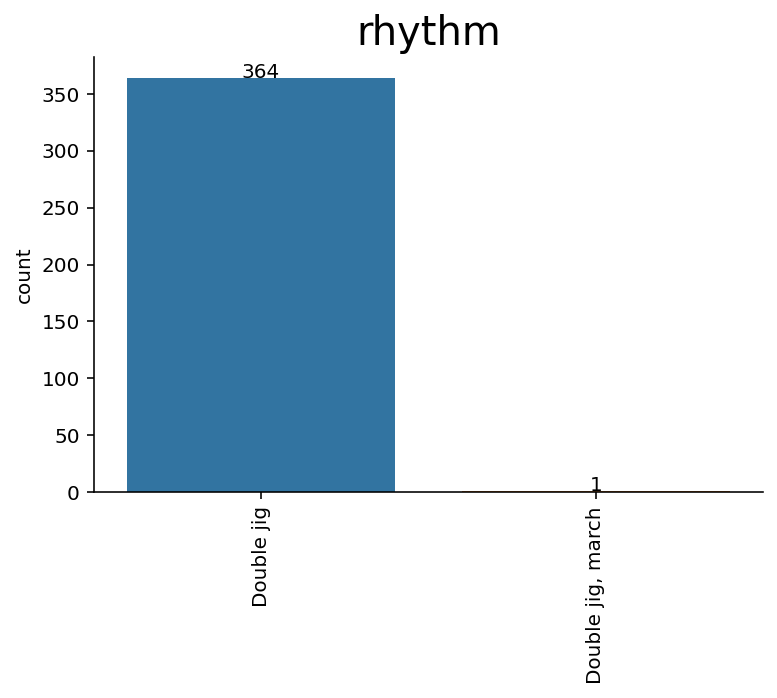

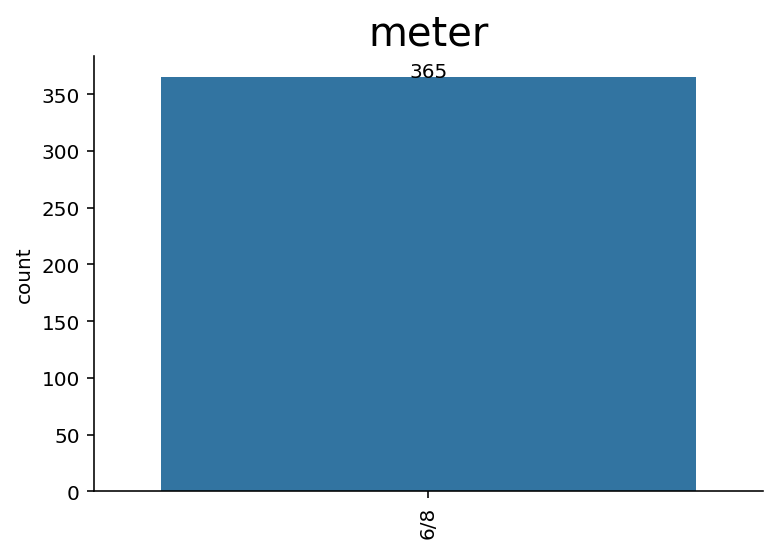

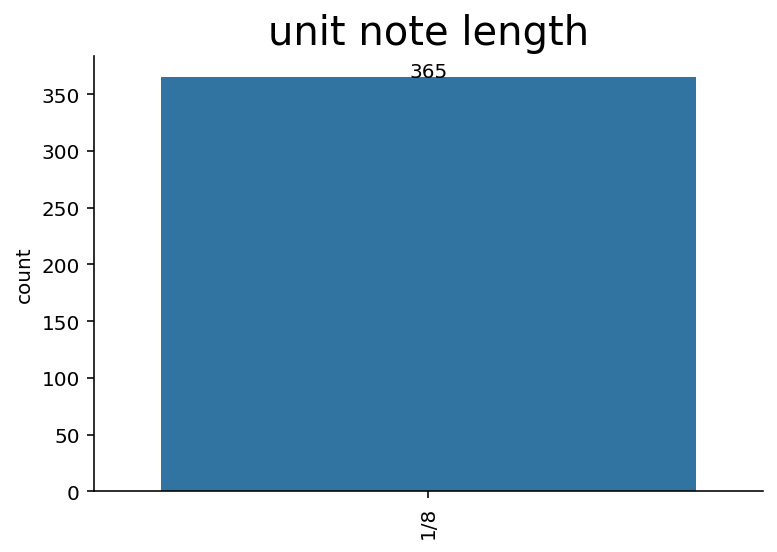

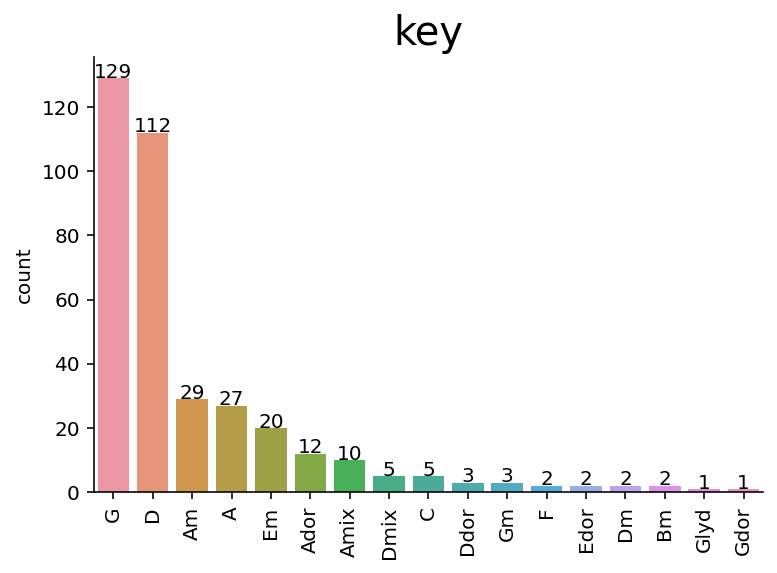

In [26]:
exclude_cols = [
    "reference number",
    "tune title",
    "file url",
    "book",
    "tune",
    "words",
    "transcription",
]
for col in [col for col in oneills_df.columns if col not in exclude_cols]:
    plt.figure()
    ordered_countplot(oneills_df[col], kind="count")
    plt.xticks(rotation=90)
    plt.title(col, fontsize=20)
    plt.ylabel("count")
    plt.show()

In [27]:
oneills_df["book"].str.slice(
    stop=len("Francis O'Neill: 'The Dance Music of Ireland' (1907)")
).value_counts()

Francis O'Neill: "The Dance Music of Ireland" (1907)    365
Name: book, dtype: int64

In [28]:
for idx in oneills_df.index[~oneills_df["words"].isna()]:
    ref, title, words = oneills_df.loc[idx, ["reference number", "tune title", "words"]]
    comment = "\n".join(words.split(" --- "))
    print(f"Tune {ref} \"{title}\", has comments:\n{comment}\n")

Tune 30 "Welcome to Cork", has comments:
W:
W:added = for f in bar 11

Tune 117 "The highlander", has comments:
W:
W:1) Org. not dotted.

Tune 154 "The Antrim lasses", has comments:
W:
W:Bar 10-11: Originally a mixture of g naturals and g sharps:
W:gfg =G2g|=gfg G2B

Tune 250 "Paddy in London", has comments:
W:
W:Bar 12, last note (chord) org. 4th note

Tune 264 "The banks of Lough Gowna", has comments:
W:
W:Last note on each line org. not dotted

Tune 333 "Miss Downing's fancy", has comments:
W:
W:1) org. not dotted.

Tune 361 "The Drogheda weavers", has comments:
W:
W:Bar 8 last note org. 4th note

Tune 365 "Merry Mary", has comments:
W:
W:1) Org. not dotted.



## Tune analysis

In [29]:
tunes = [abc["tune"] for abc in parsed_abc]

In [30]:
tokens_set = set(list(''.join(tunes)))
idx2token = list(tokens_set)
vocab_size = len(idx2token)
print(f"vocabulary size: {vocab_size}")
print(f"vocabulary (each token separated by a space): \n{' '.join(sorted(tokens_set))}")

vocabulary size: 48
vocabulary (each token separated by a space): 
  " ' ( ) , - . / 1 2 3 4 : < = > A B C D E F G H K L M S T [ ] ^ _ a b c d e f g s t z { | } ~


### Number of tokens in a piece (not true length as repeats are notated |: :|)

In [31]:
tune_len = [len(tune.replace(' ', '')) for tune in tunes]

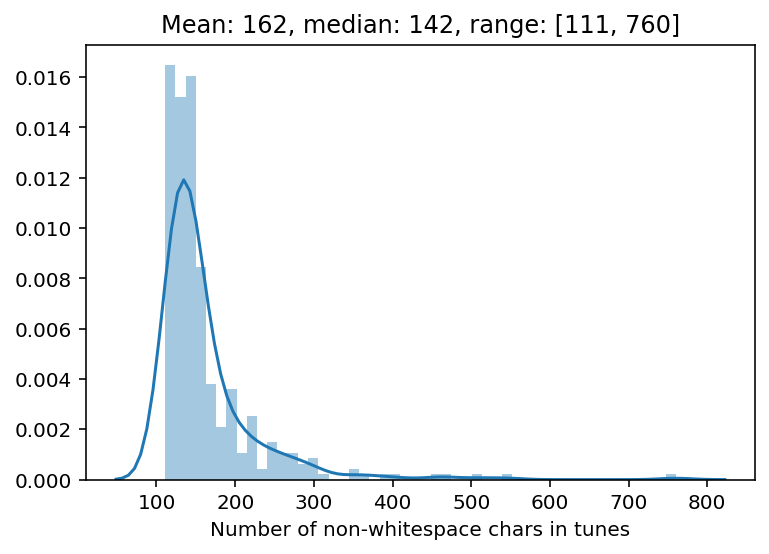

In [32]:
max_len = max(tune_len)
med_len = np.median(tune_len)
mean_len = np.mean(tune_len)
min_len = min(tune_len)
sns.distplot(tune_len)
plt.xlabel("Number of non-whitespace chars in tunes")
plt.title(
    f"Mean: {int(mean_len)}, median: {int(med_len)}, range: [{min_len}, {max_len}]"
);

### How many tunes have ornamentation etc. in them?

Summary:

* K - key change mid tune
* L - a `>` accent on the subsequent note
* M - a lower mordent <img src="https://www.8notes.com/school/lessons/all/lowermordent1.1.gif" alt="Lower Mordent" width=200>
* S, and O - segno (sign), and coda <img src="https://www.liveabout.com/thmb/1Qfs7xts_x04z1HXOWLPeibyivA=/735x0/GL_segno-coda-music-56a72d345f9b58b7d0e7996b.png" alt="segno" width="100"/>
* T - `tr' trill
* ~ - irish roll
* z - rest
* { } - grace note
for these, see http://abcnotation.com/wiki/abc:standard:v2.1
* "..." - text annotations

Exceptions found:
* The one tune containing 's' and 't' has a text annotation saying 1st and 2nd

In [33]:
query_strings = ["K", "L", "M", "S", "T", "t", "s", "~", "z", "{", "\""]
weird_tunes = {}
for query in query_strings:
    weird_tunes[query] = [
        (idx, tune) for (idx, tune) in enumerate(tunes) if query in tune
    ]

In [34]:
{k: len(v) for k, v in weird_tunes.items()}

{'K': 3,
 'L': 1,
 'M': 18,
 'S': 11,
 'T': 59,
 't': 1,
 's': 1,
 '~': 19,
 'z': 21,
 '{': 101,
 '"': 5}



========== Exceptions contiaining 'K' (3) ==========

reference number: 228
tune title: Come to dinner
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 228
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0228.abc
meter: 6/8
unit note length: 1/8
key: Ador
tune: e|(c<A)A A2A|EAB cBA|(B<G)G G2G|BGB gdB|(c<A)A A2B|cde agf|gec Bed|(c<A)A A2:| K:A |:e|aga bag|aec Ace|dBG EGB|Acf efg|aga bag|aec Ace|dBG EGB|(c<A)A A2:|




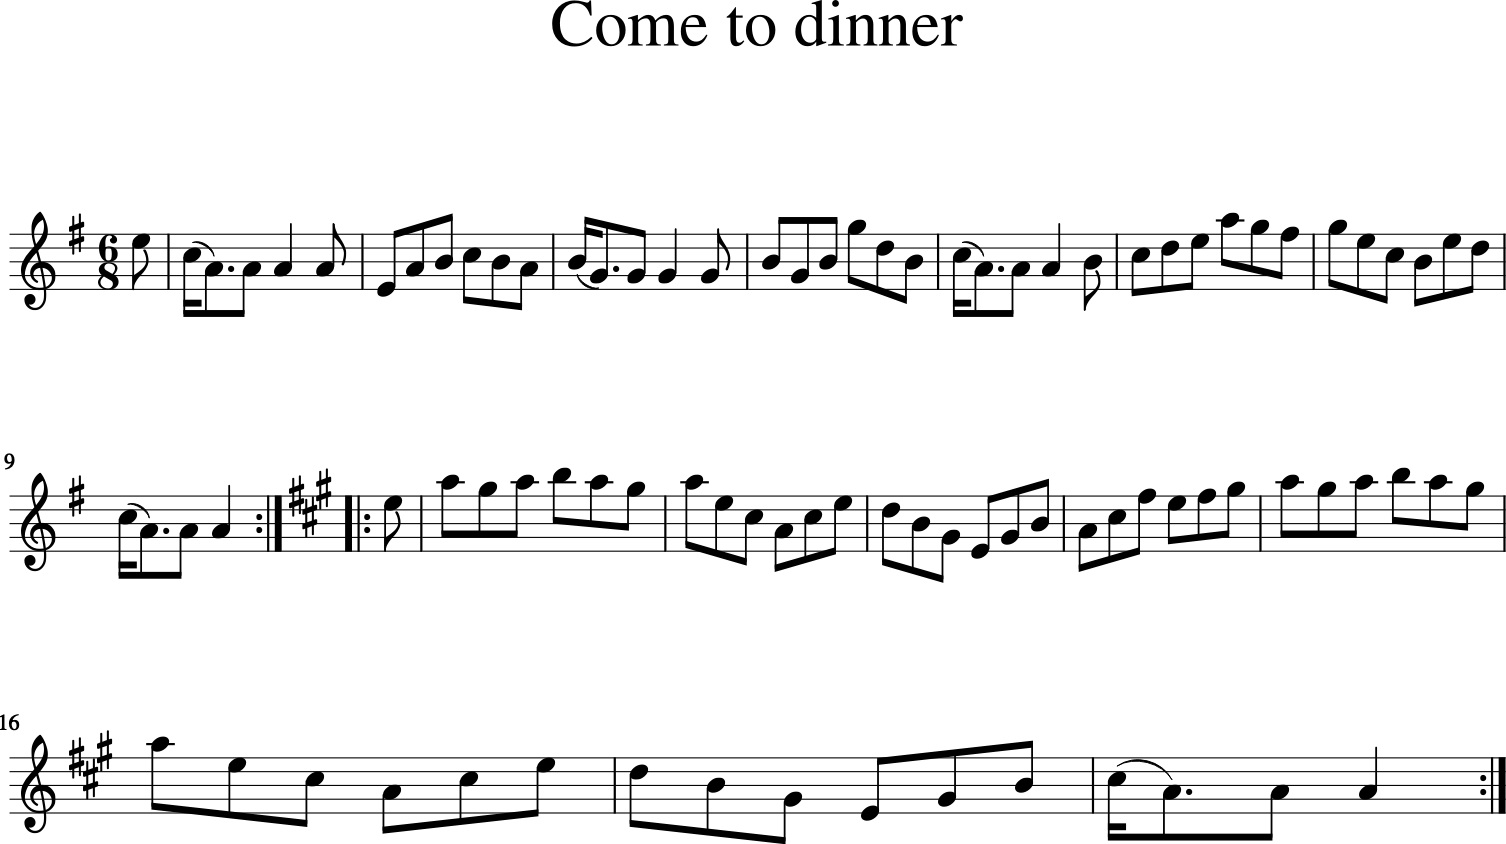




 ... 



========== Exceptions contiaining 'L' (1) ==========

reference number: 122
tune title: Charley the prayermaster
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 122
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0122.abc
meter: 6/8
unit note length: 1/8
key: G
tune: A|GED G2A|Bee dBA|GED GAB|({d}c)BA BGE|GED G2A|Bee dBA|GED G2A|BGG G2:| |:d|e2d Le2d|efe edB|d2B Ld2B|dge dBG|e2d Le2f|{a}gfe dBA|GED G2A|BGG G2:|




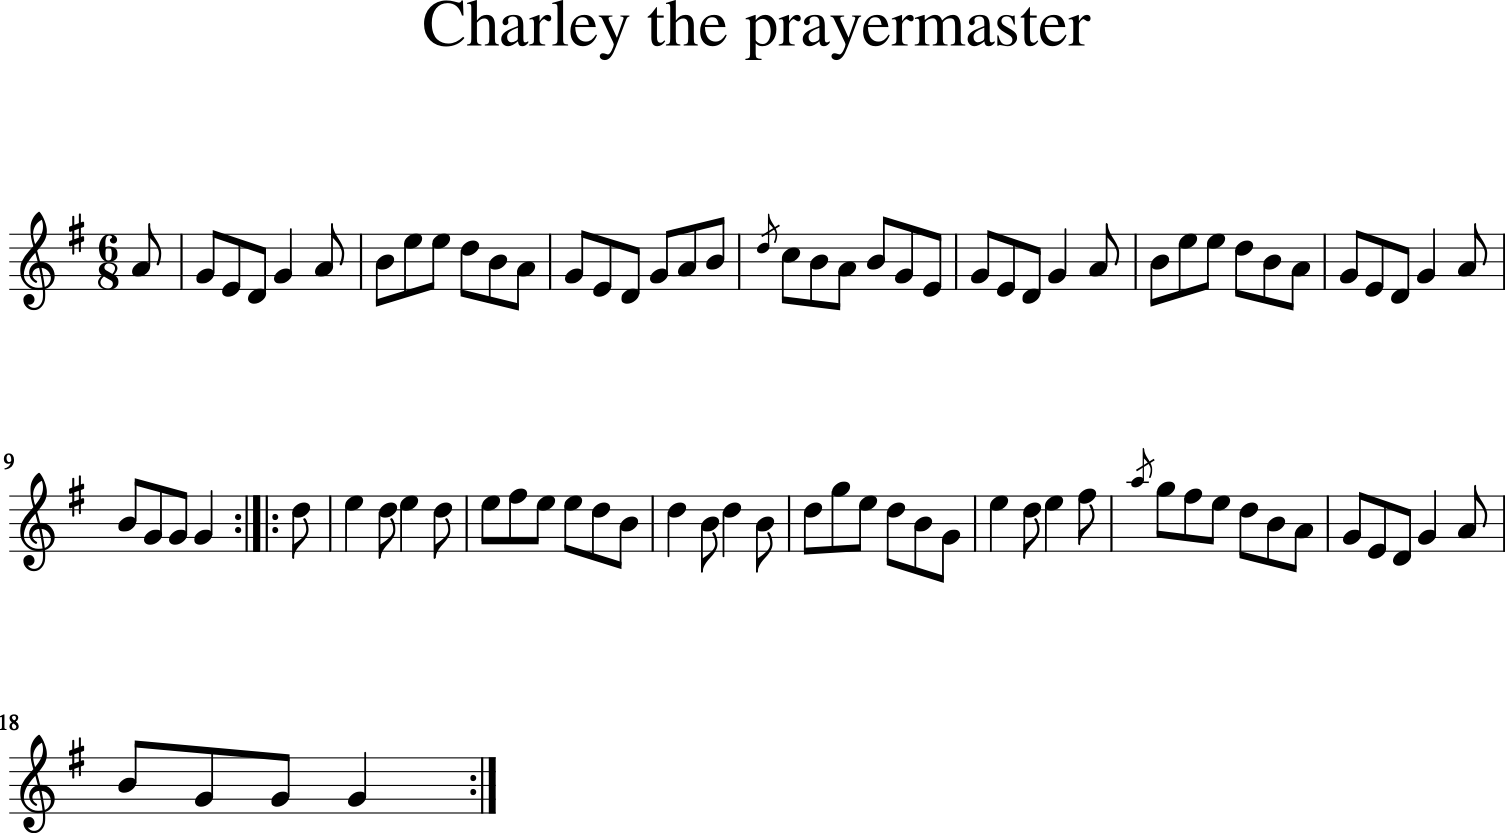





========== Exceptions contiaining 'M' (18) ==========

reference number: 12
tune title: The gold ring
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 12
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0012.abc
meter: 6/8
unit note length: 1/8
key: G
tune: d|cAG GFG|cAG G2d|cAG GFG|cAGF2 d|cAG GFG| cAG TA2 G|FGA (Mfed)|cAG G2:|d|cAd cAd| cAG G2d|cAd cAd|cAG F2d|cAd cAd|cAG TA2G|FGA (Mfed)|cAGG2:|(3d/e/f/| gag gdc|BGGG2 d/e/|=fgf fc_B| A=FF F2d|gag gdc|BGG G2d|=fgf fed|cAG G2:|(3d/e/f/| gdd fdd|gdd fdd|gdd fdd|cAG G2 (3d/e/f/|gdd fdd| gdd fdd|(f/g/a)g f2d|cAG G2:|D|Gdd Gdd|cAG G2A|TB2G TA2G| cAG F2A|TB2G TA2G|TB2G TA2G|FGA (Mfed)| cAG G2 :| (G/A/)|BGB AFA|DED FED|Add fed|cAG FGA| BGB AFA|DED FED|Add fed|cAGG2:| |:(G/A/)|BAB DED|AFA DED|Add fed|cAG FGA|BAB DED| AFA DED|Add fed|cAGG2:|




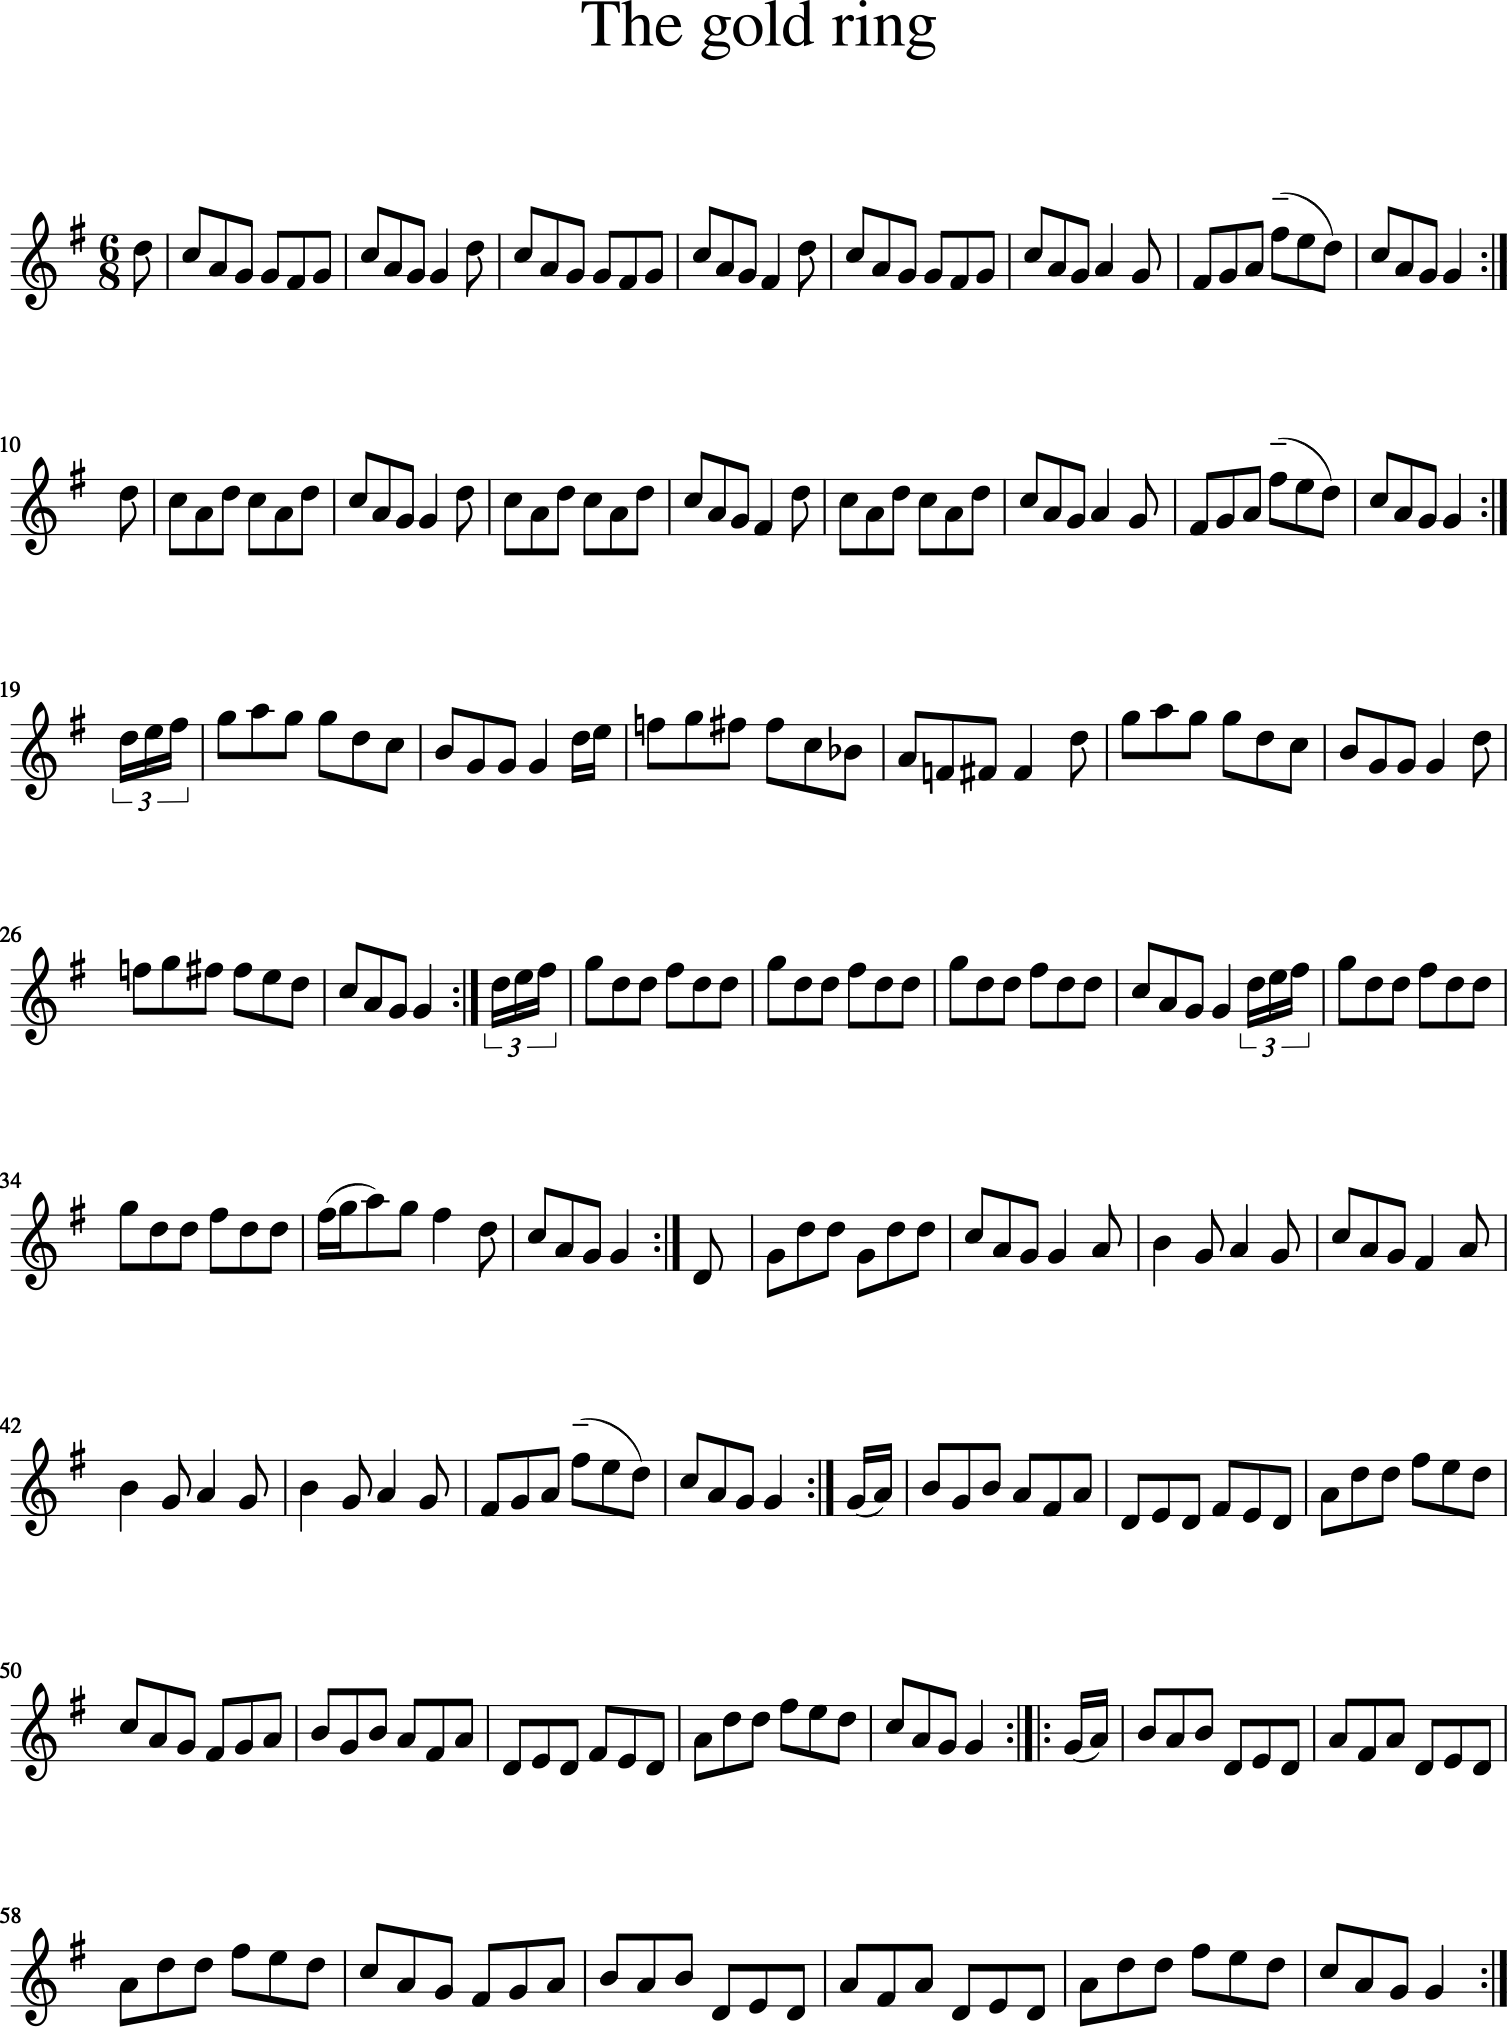




 ... 



========== Exceptions contiaining 'S' (11) ==========

reference number: 29
tune title: Cherish the ladies
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 29
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0029.abc
meter: 6/8
unit note length: 1/8
key: D
tune: (3A/B/c/S|dFF AFF|DFA AGF|BEE GEE|GBA GFE|dFF AFF| DFA AFA|Bcd efg|fdd d2 H :|(3A/B/c/|dfd cec| dfd AGF|BEE GEE|GBA GFE|dfd cec|dfd AGF|Bcd efg| fdd d2:|A|dfd cec|dfd AGF|B z E G z E| (GBA) GFE|dGd cFc|dGd A2G|(A>Bc/d/) efg| fdd d2:| B|Add fdd|add fdd|(A/B/c)d gfg|ece gfe| agf bge|afd cBA|(3f/g/a/ B2 AGF|GEF GFE:|f2f afd| fed cde|g2g gfg|ece gfe|agf bge|afd cBA| fdB AGF|GEF GFE:|DFA dAF|DFA BGE|DFA dAF| GEF GFE|DFA DGB|DFA d2e|fdB AGF|GEF GFES:|




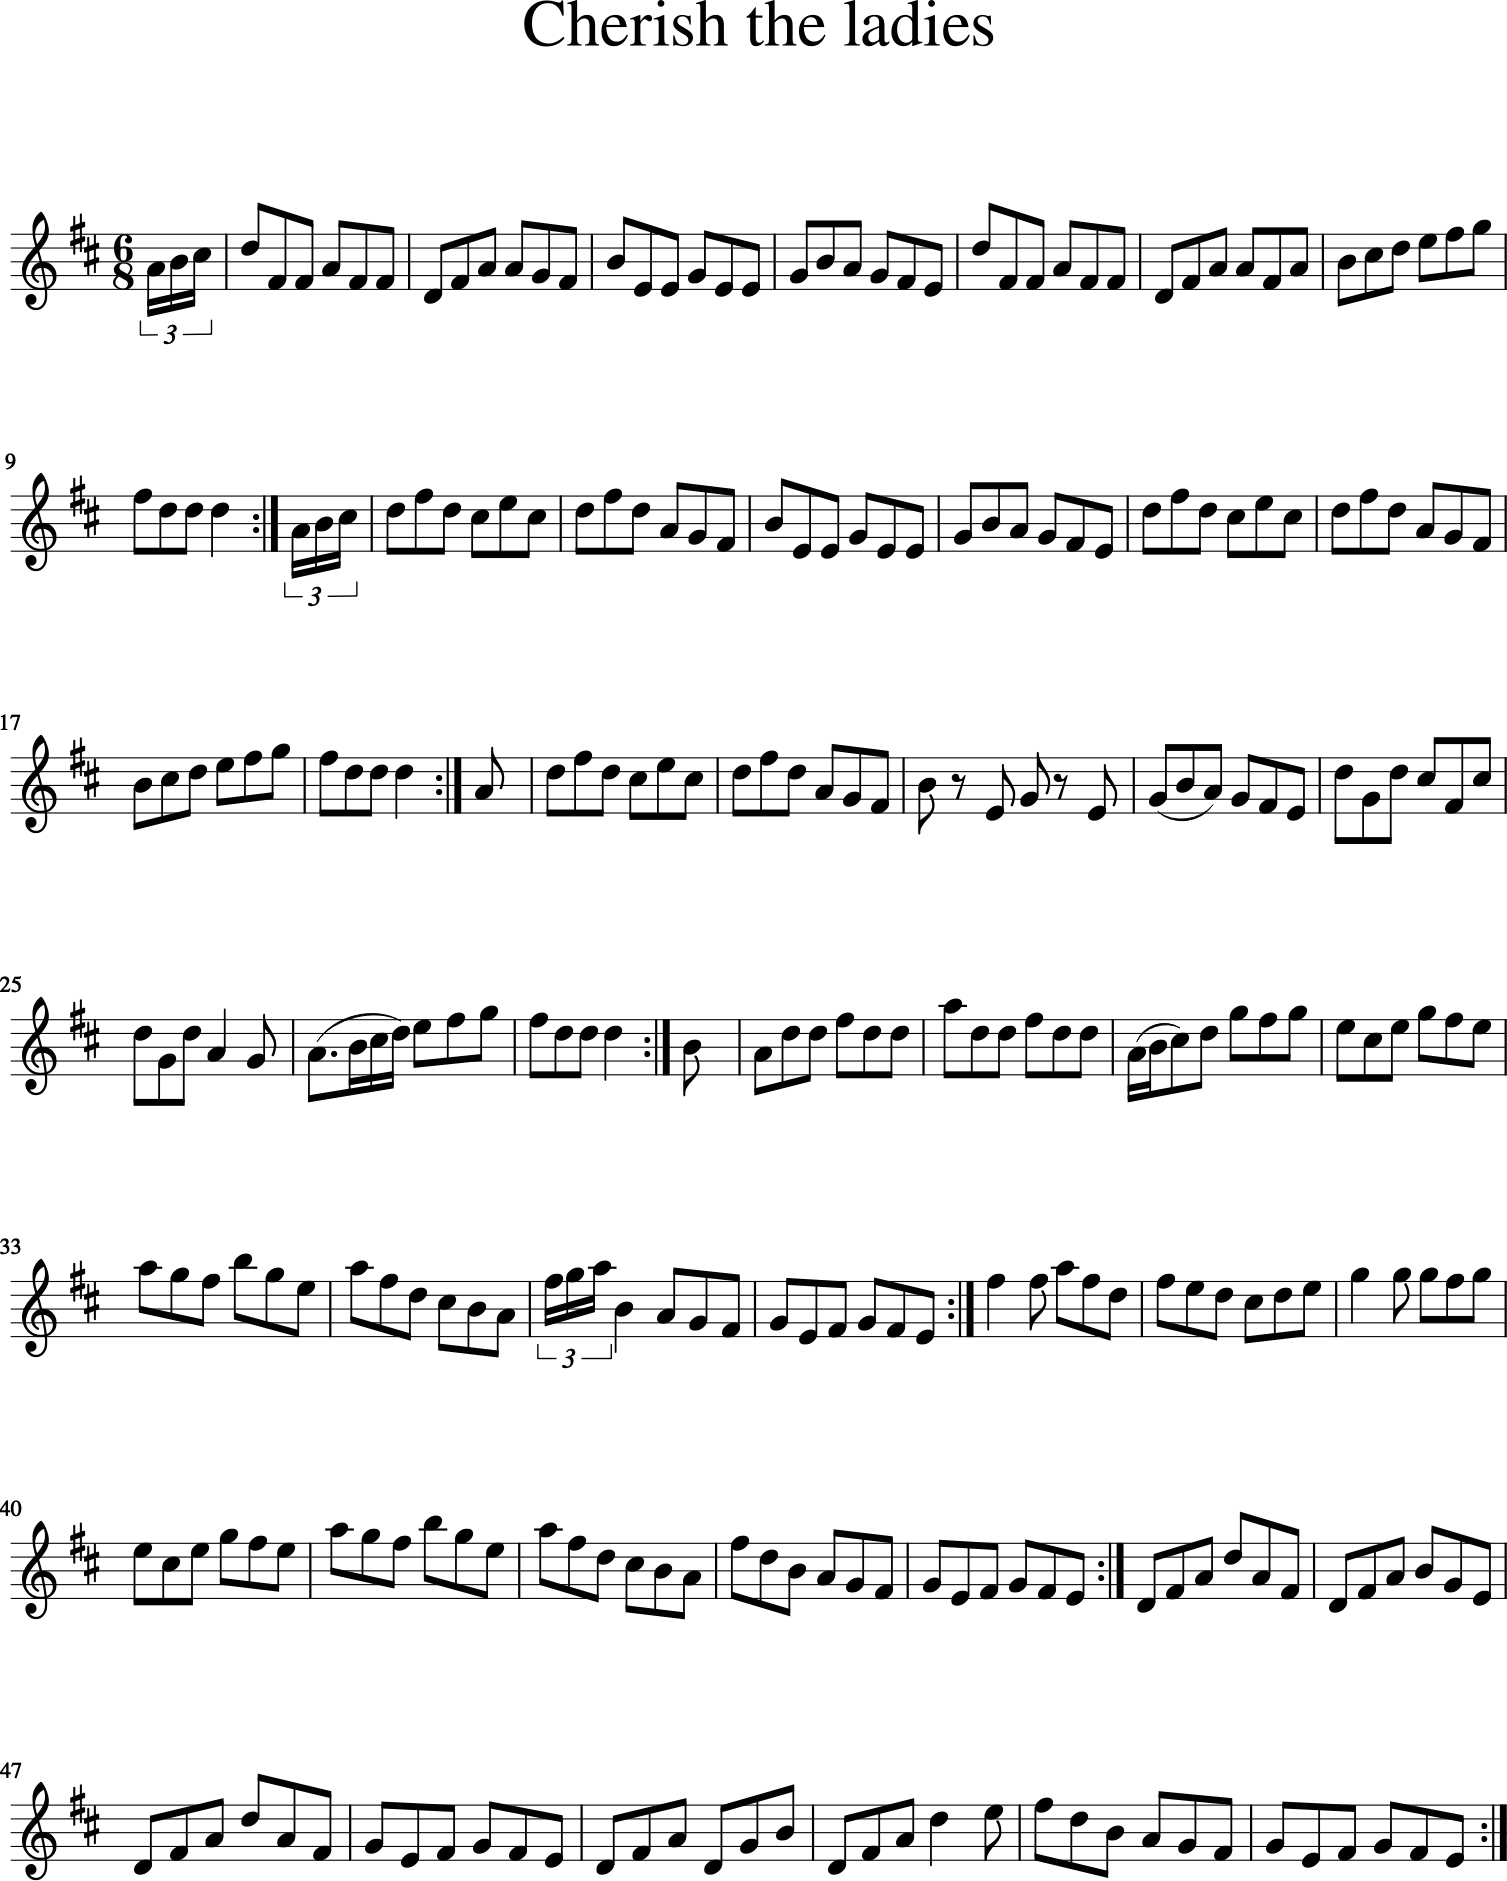




 ... 



========== Exceptions contiaining 'T' (59) ==========

reference number: 12
tune title: The gold ring
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 12
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0012.abc
meter: 6/8
unit note length: 1/8
key: G
tune: d|cAG GFG|cAG G2d|cAG GFG|cAGF2 d|cAG GFG| cAG TA2 G|FGA (Mfed)|cAG G2:|d|cAd cAd| cAG G2d|cAd cAd|cAG F2d|cAd cAd|cAG TA2G|FGA (Mfed)|cAGG2:|(3d/e/f/| gag gdc|BGGG2 d/e/|=fgf fc_B| A=FF F2d|gag gdc|BGG G2d|=fgf fed|cAG G2:|(3d/e/f/| gdd fdd|gdd fdd|gdd fdd|cAG G2 (3d/e/f/|gdd fdd| gdd fdd|(f/g/a)g f2d|cAG G2:|D|Gdd Gdd|cAG G2A|TB2G TA2G| cAG F2A|TB2G TA2G|TB2G TA2G|FGA (Mfed)| cAG G2 :| (G/A/)|BGB AFA|DED FED|Add fed|cAG FGA| BGB AFA|DED FED|Add fed|cAGG2:| |:(G/A/)|BAB DED|AFA DED|Add fed|cAG FGA|BAB DED| AFA DED|Add fed|cAGG2:|




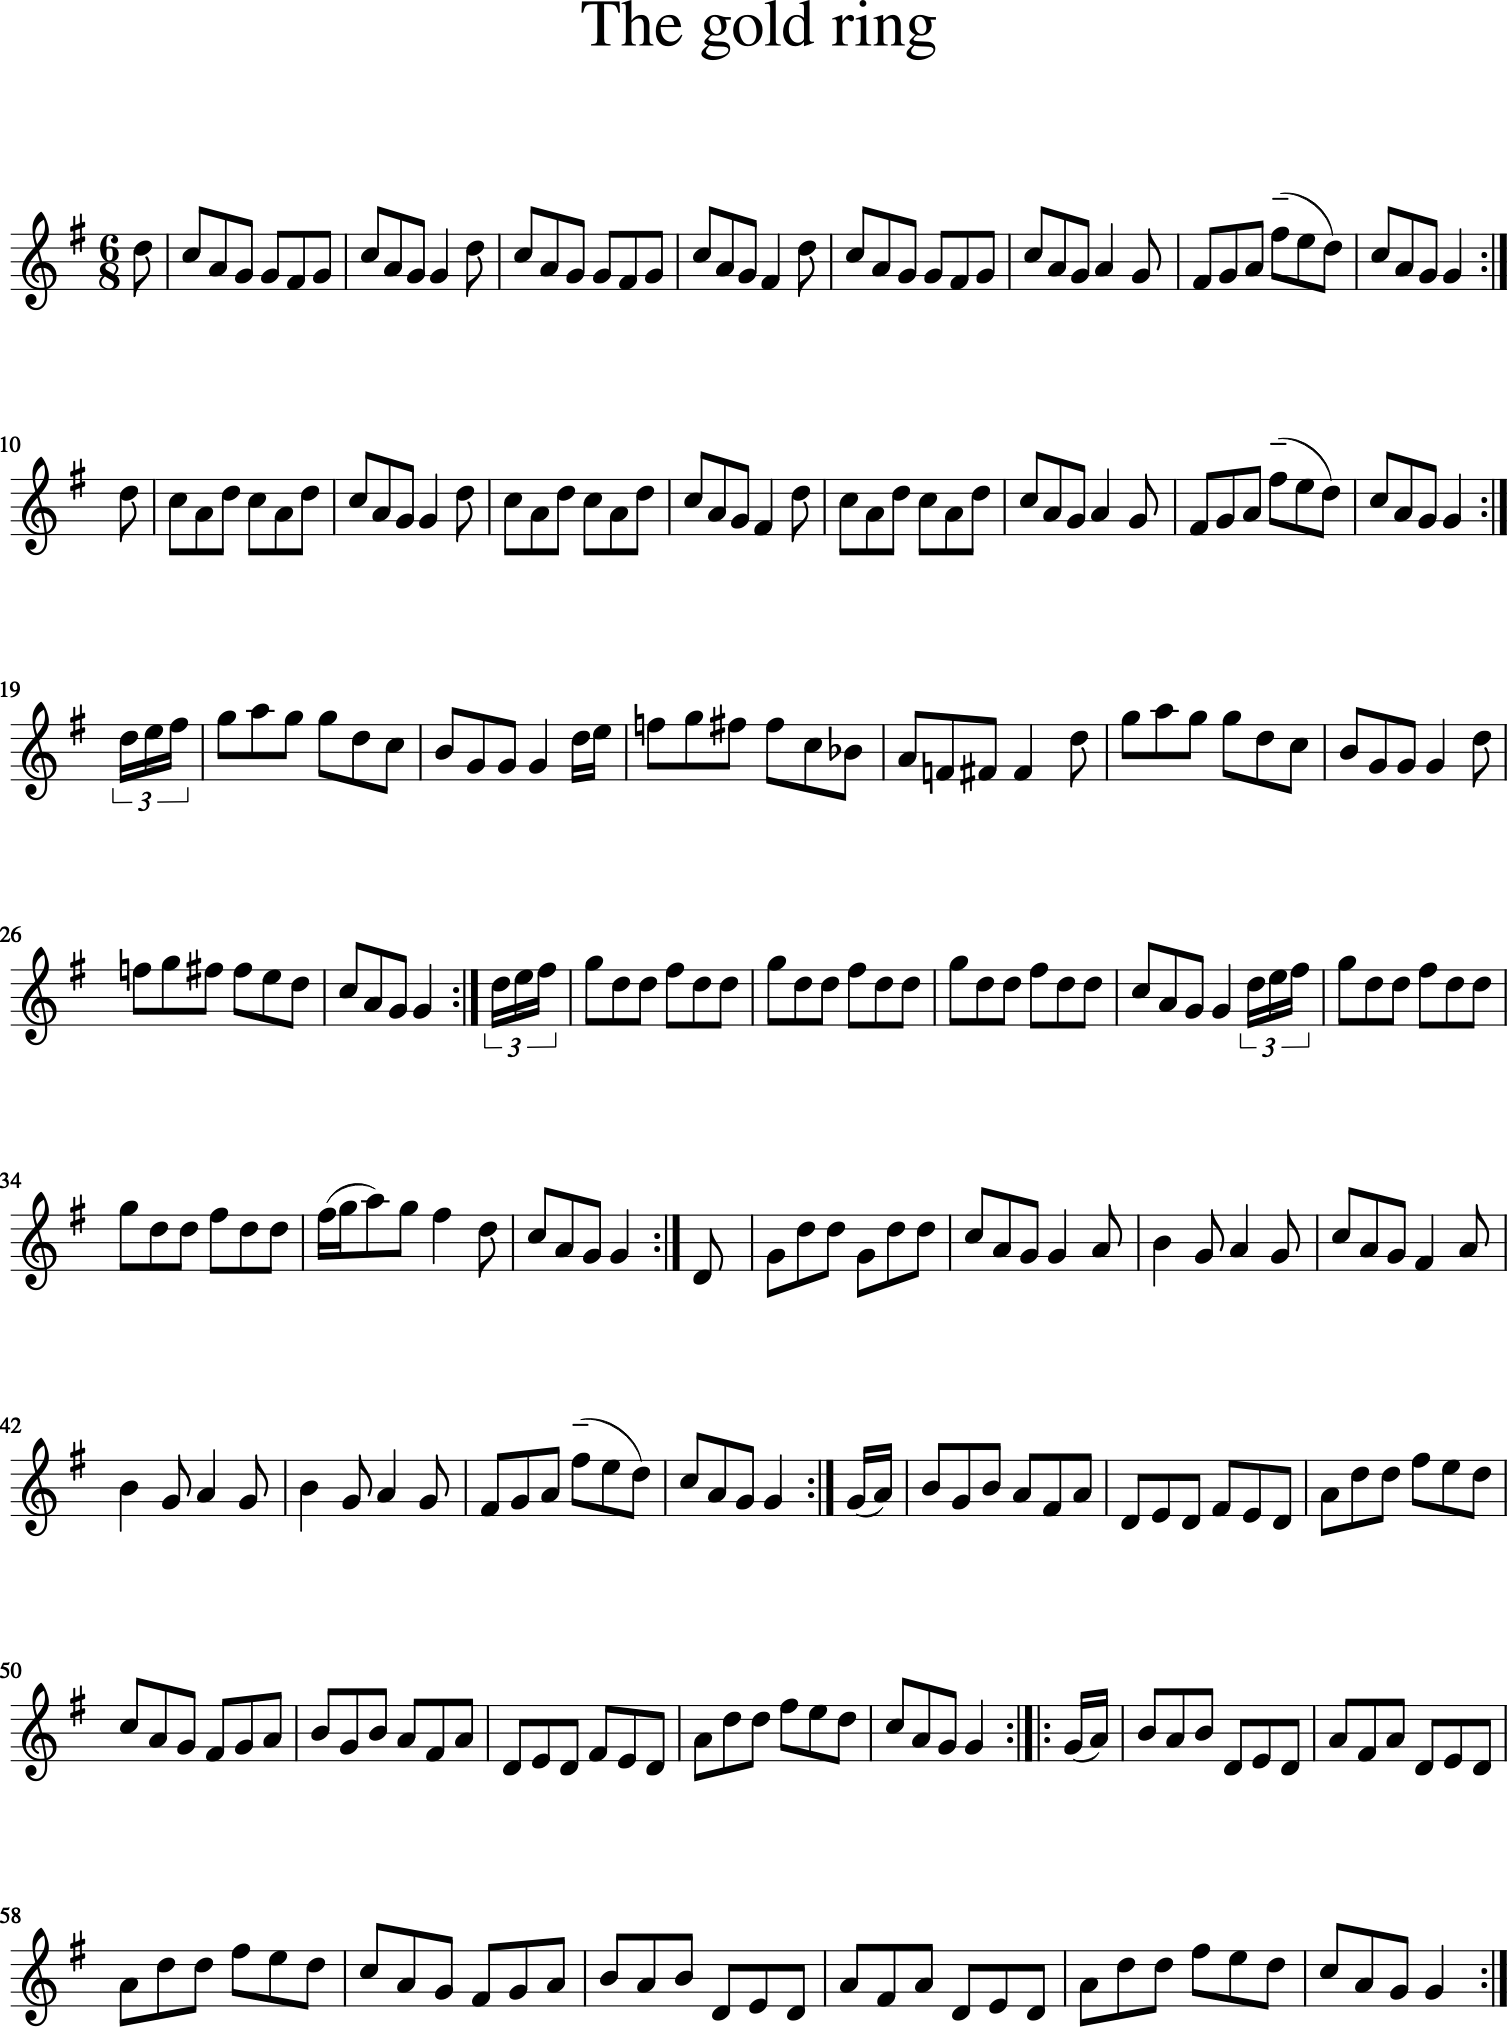




 ... 



========== Exceptions contiaining 't' (1) ==========

reference number: 78
tune title: Happy to meet and sorry to part
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 78
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0078.abc
meter: 6/8
unit note length: 1/8
key: G
tune: g/f/S|edc BAB|GEF G2A|Bdd Bee|Bdd dge|dBG AGE|DEG G2A|Bed B2A|BGG G2:| |:e/f/|gag fed|Bdd def|gag fed|Bee e2f|gag gfe|dBd g2 "^2d""_1st"[ef]|[1 dBG AGE|DEG G2:|[2 gfg eag|fef gfeS|]




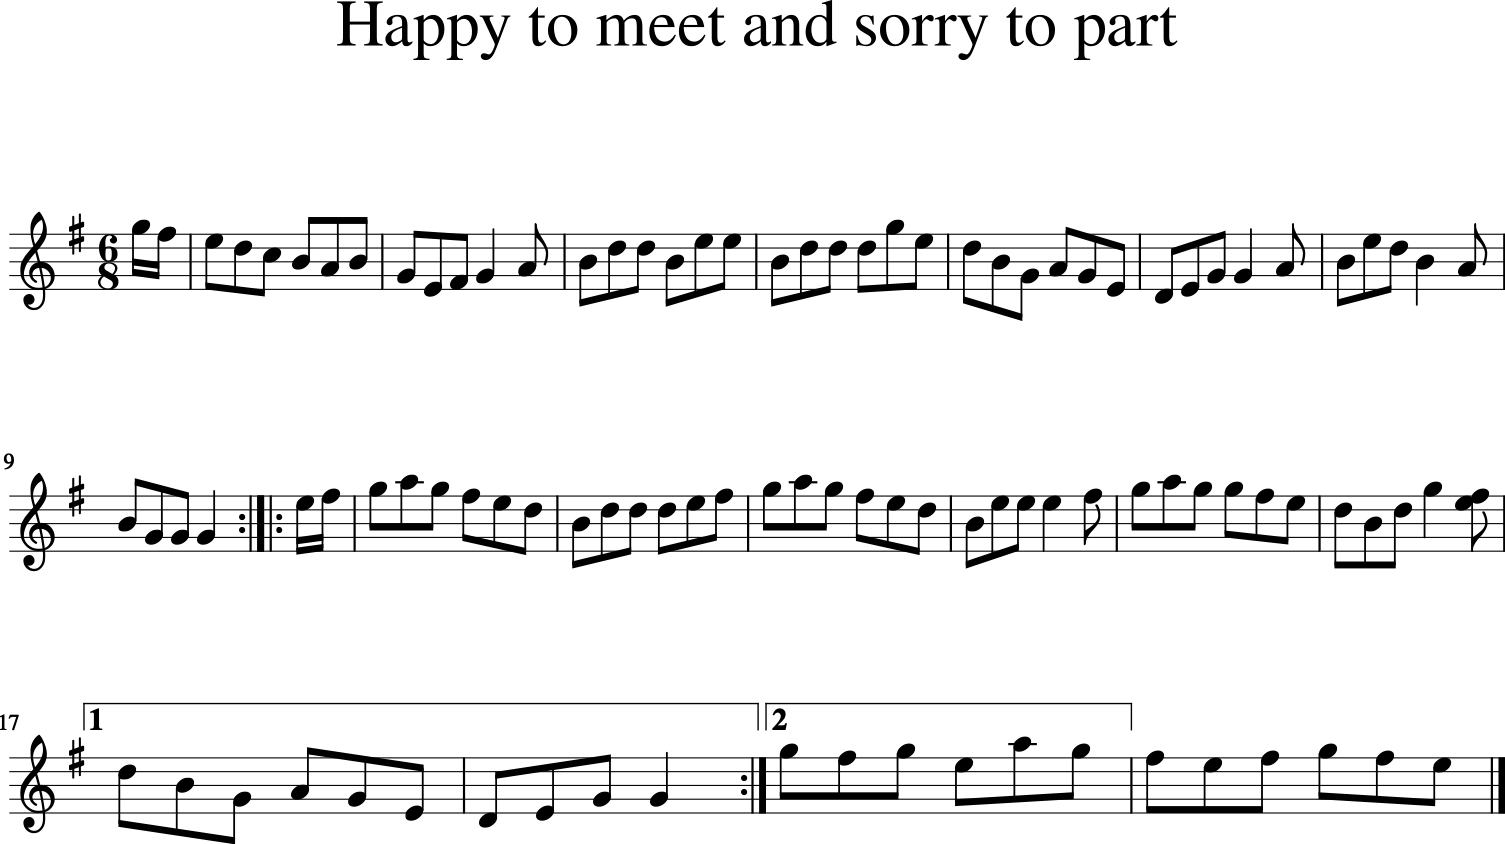





========== Exceptions contiaining 's' (1) ==========

reference number: 78
tune title: Happy to meet and sorry to part
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 78
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0078.abc
meter: 6/8
unit note length: 1/8
key: G
tune: g/f/S|edc BAB|GEF G2A|Bdd Bee|Bdd dge|dBG AGE|DEG G2A|Bed B2A|BGG G2:| |:e/f/|gag fed|Bdd def|gag fed|Bee e2f|gag gfe|dBd g2 "^2d""_1st"[ef]|[1 dBG AGE|DEG G2:|[2 gfg eag|fef gfeS|]




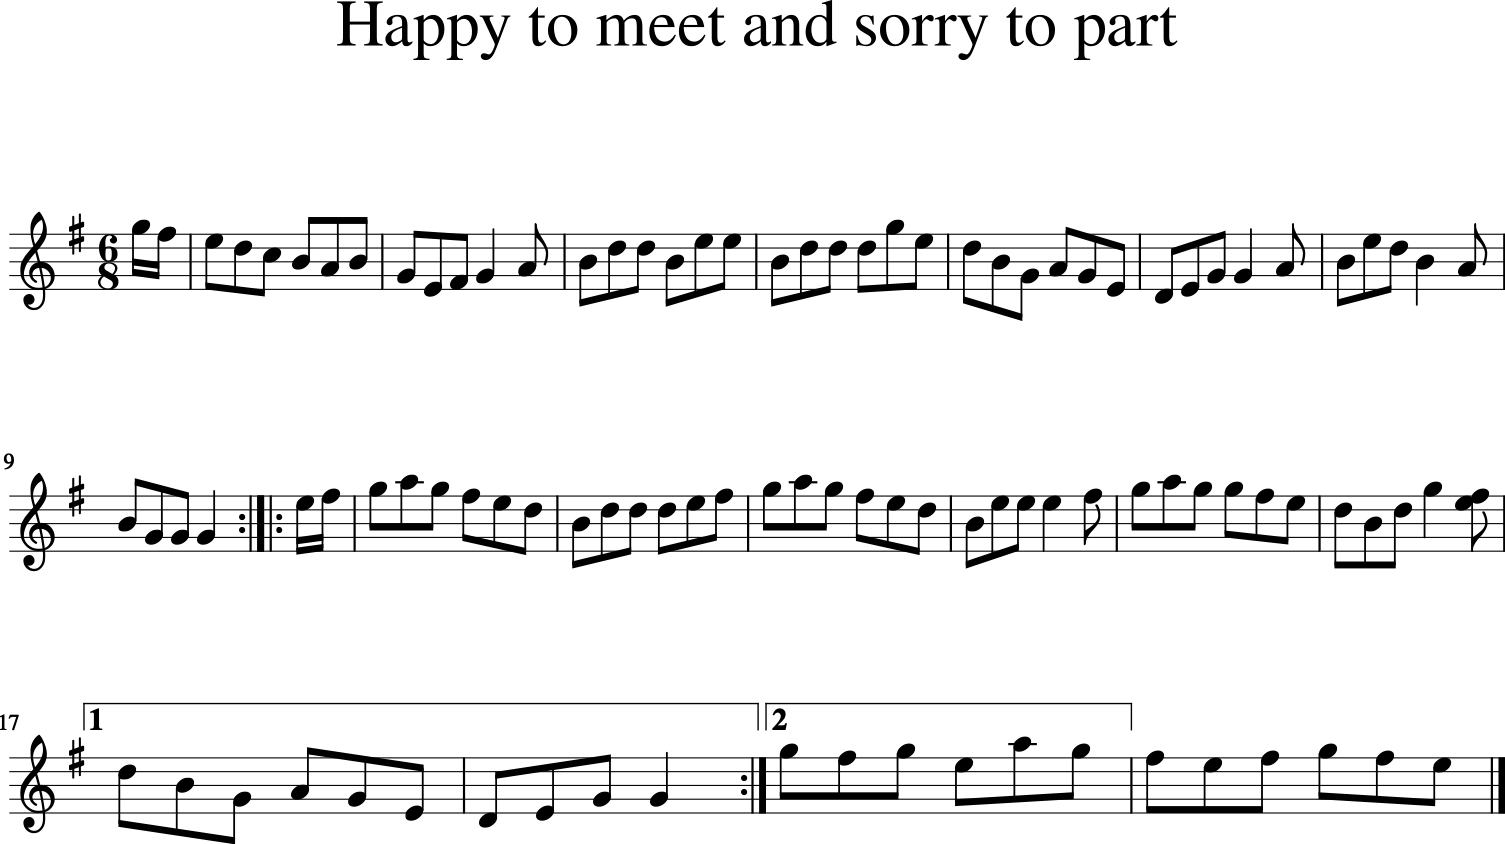





========== Exceptions contiaining '~' (19) ==========

reference number: 6
tune title: Doctor O'Neill
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 6
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0006.abc
meter: 6/8
unit note length: 1/8
key: D
tune: A|~d3 AFD|E2F G2 A|BGB Bcd|AGF EFA|~d3 AFD| E2 F G2 A|BGB Bcd|AFD D2:|A|~d3 ceA|dfe dcB| AFA Bcd|AGF EFA|~d3 ceA|dfe dcB|AFA Bcd|AFD D2:|g| {g}fef afd|ded fed|gbg faf|gee e2 g| {g}fef afd|ded fed|gbg fag|fdd d2:|g| {g}fdf ece|{e}dcB AFA|AFd AFd|AGF E2 g|{g}fdf ece|dcB AFA| AFA Bcd|AFD D2::G|FAF GBG|FAG FED|FAF GBG|AGF E2G| FAF GBG|FAG FED|BGB Bcd|AFD D2:|




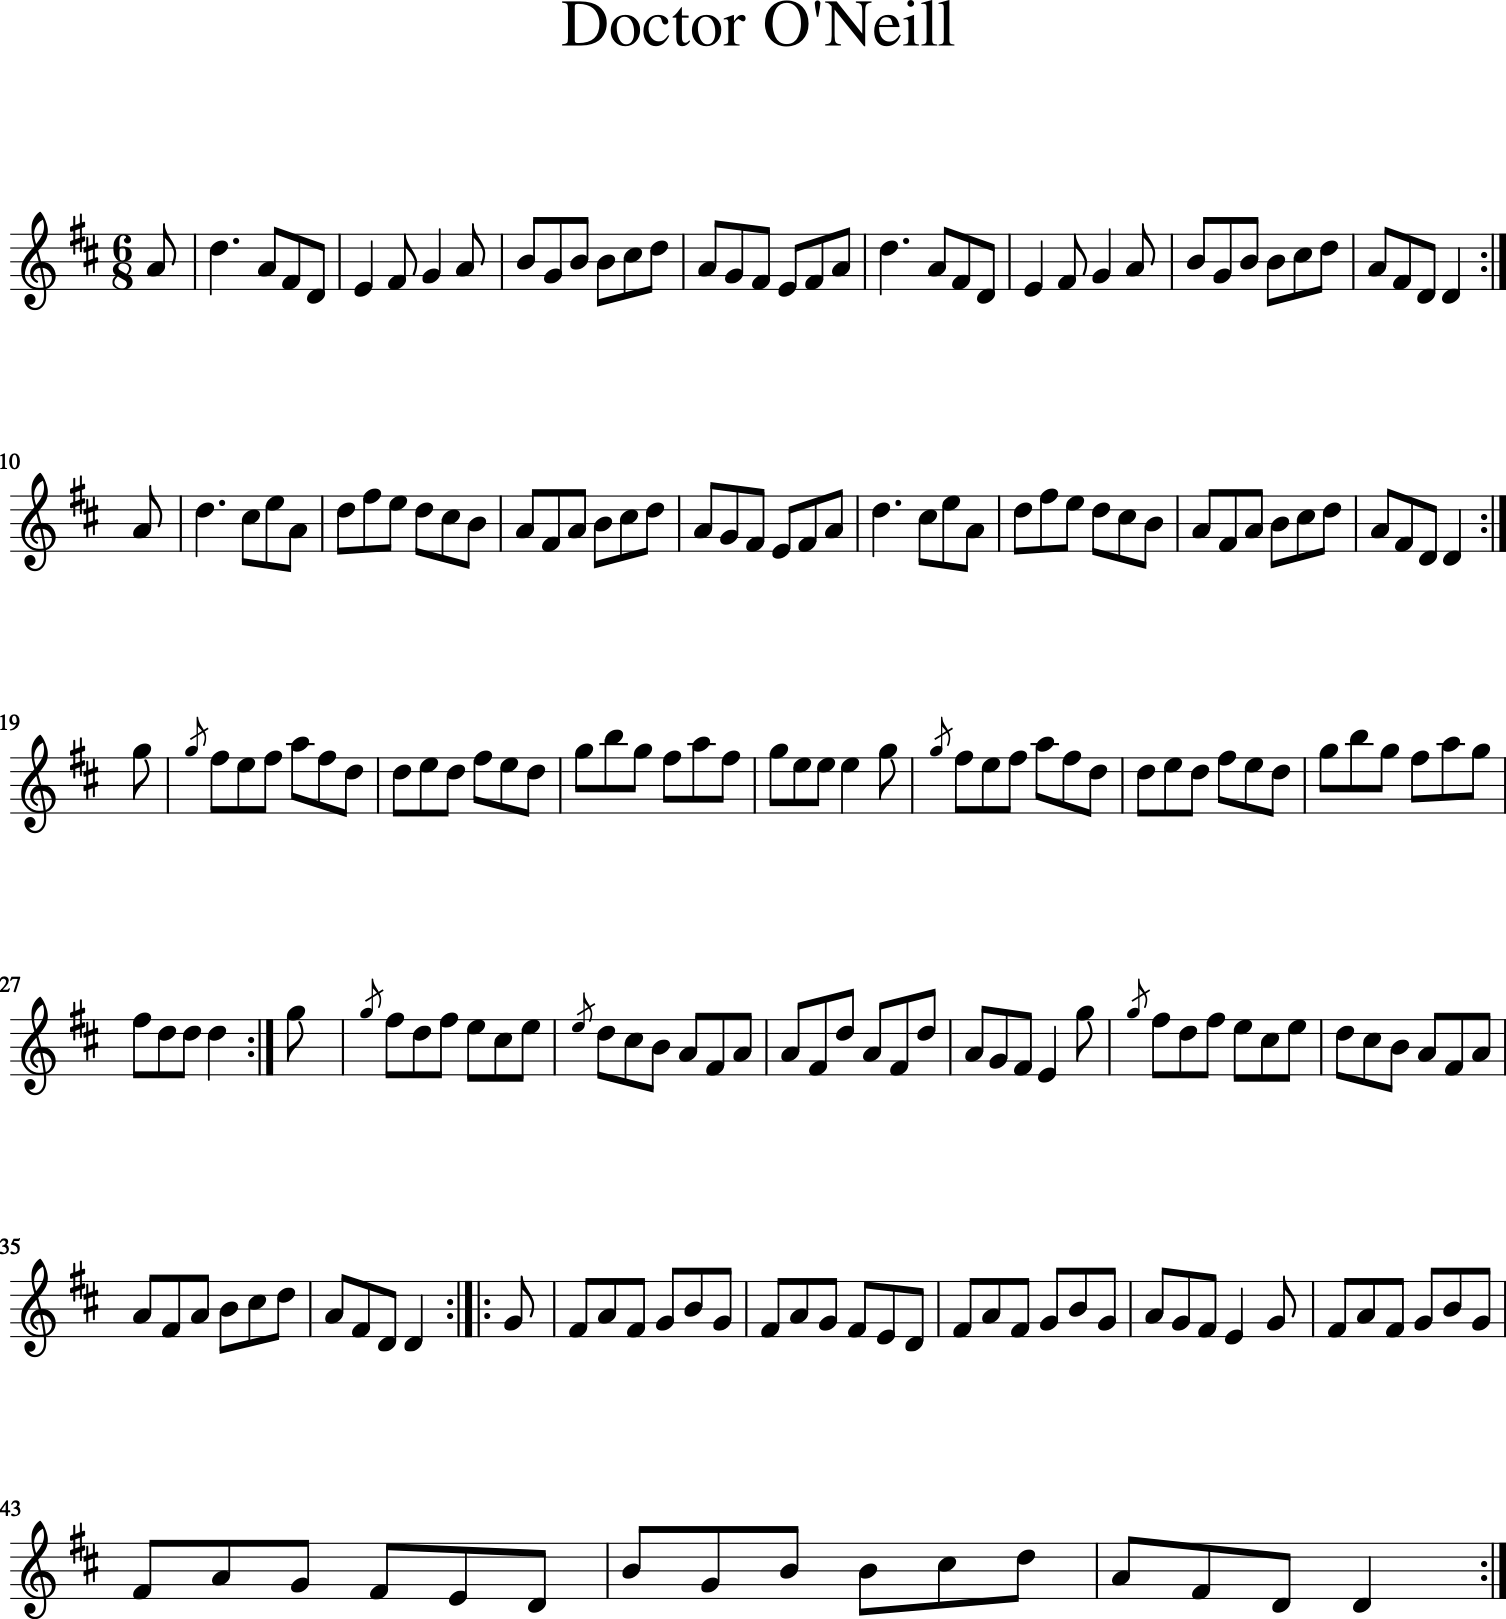




 ... 



========== Exceptions contiaining 'z' (21) ==========

reference number: 9
tune title: The pipe on the hob
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 9
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0009.abc
meter: 6/8
unit note length: 1/8
key: Am
tune: B|c3 edc|edc BAG|ABA {a}g z e|eaa ged|~c3 edc|edc deg|age dBe|ABAA2:| ^f|g3 {a}gea|age edB| ABA {a}g z e|aba eg^f| g3 {a}gea|age e^fg|age dBe|ABA A2:| B|c2cd2d|ecA AGE|c2cd2d|ecA A2B|c2cd2d|e2e ^gab|a=ge dBe|ABAA2:|




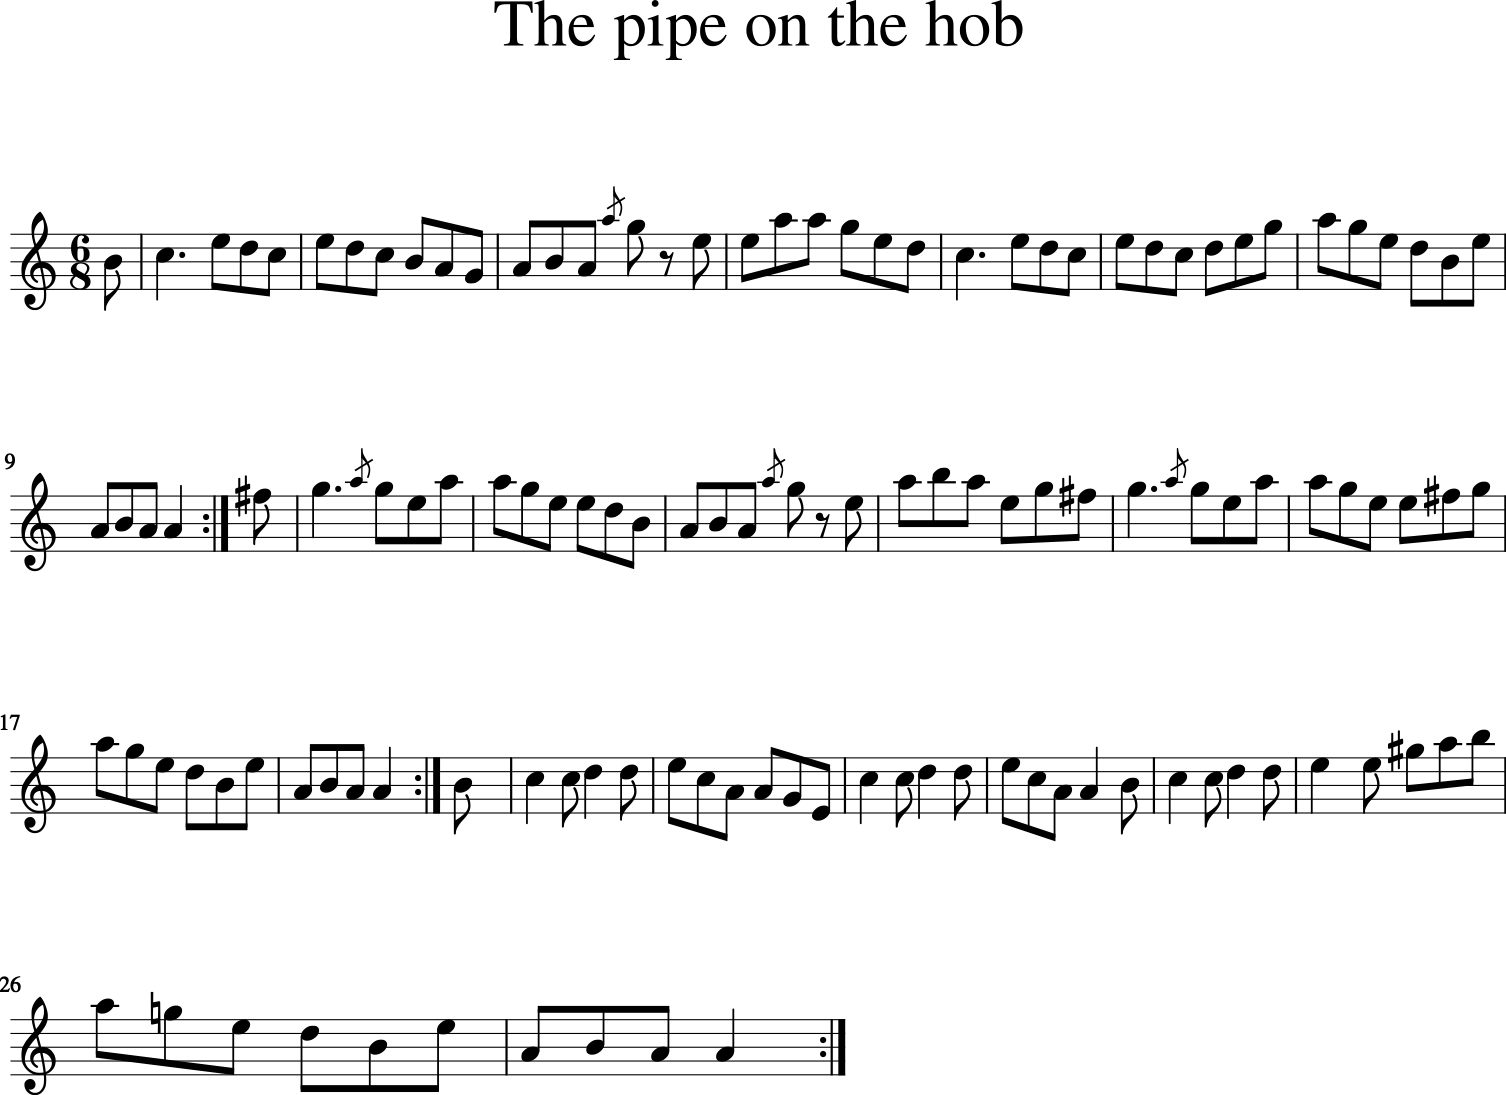




 ... 



========== Exceptions contiaining '{' (101) ==========

reference number: 2
tune title: The piper's picnic
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 2
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0002.abc
meter: 6/8
unit note length: 1/8
key: A
tune: E|AcA BGE|cde dBG| AcA BGE|{F}EDE GAB|AcA BGE|cde dBG|{d}cBA BGE|EFG A2:| (A/B/)|ceA ceA|cee edc|(B/c/d)G (B/c/d)G|Bdd dcB| cde dcB|{d}cBA Ggf|ecA GED|EFGA2:|




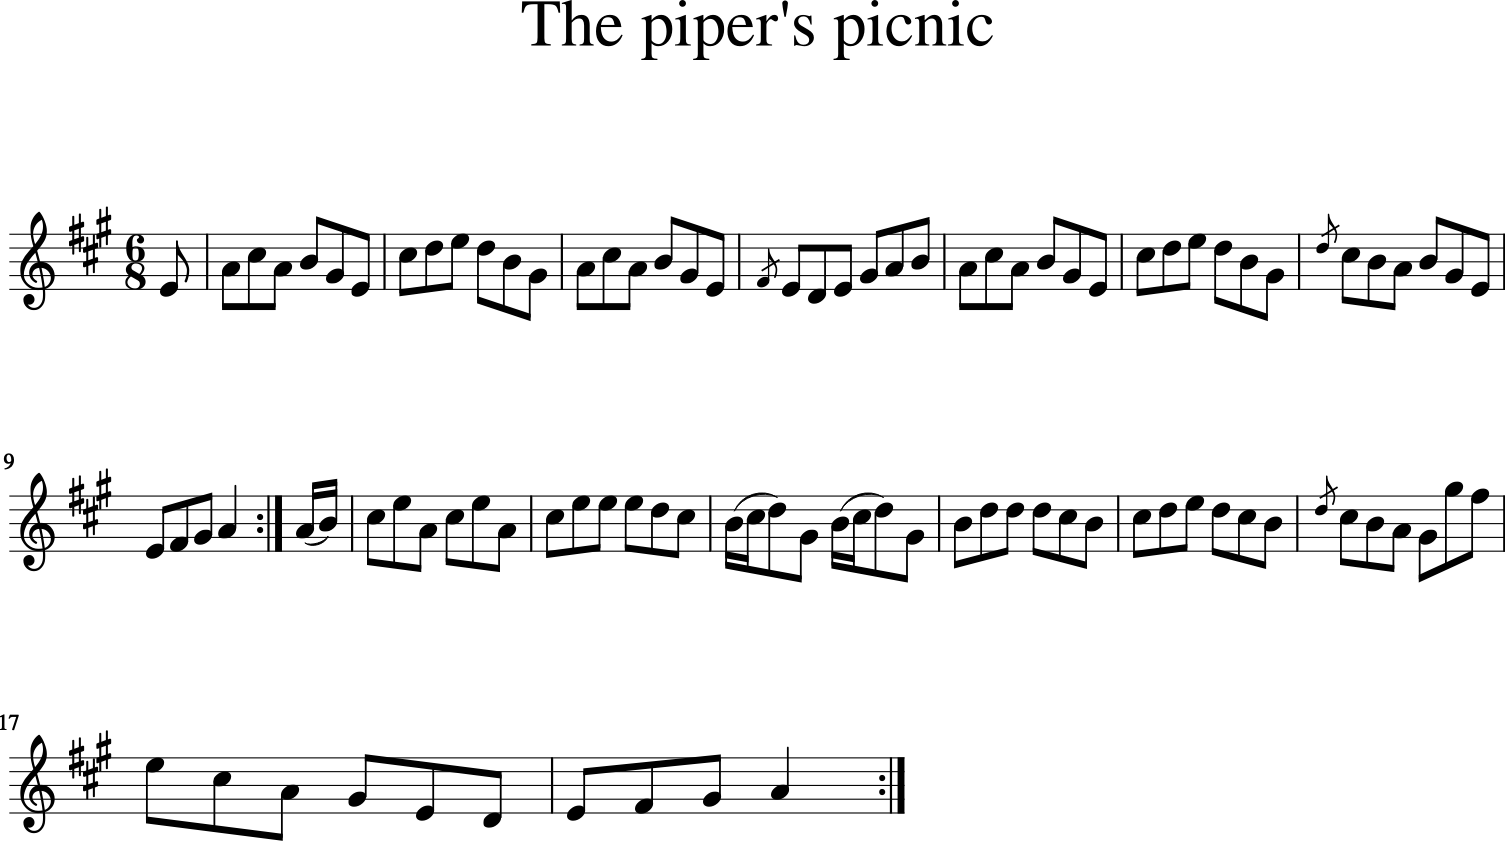




 ... 



========== Exceptions contiaining '"' (5) ==========

reference number: 78
tune title: Happy to meet and sorry to part
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 78
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0078.abc
meter: 6/8
unit note length: 1/8
key: G
tune: g/f/S|edc BAB|GEF G2A|Bdd Bee|Bdd dge|dBG AGE|DEG G2A|Bed B2A|BGG G2:| |:e/f/|gag fed|Bdd def|gag fed|Bee e2f|gag gfe|dBd g2 "^2d""_1st"[ef]|[1 dBG AGE|DEG G2:|[2 gfg eag|fef gfeS|]




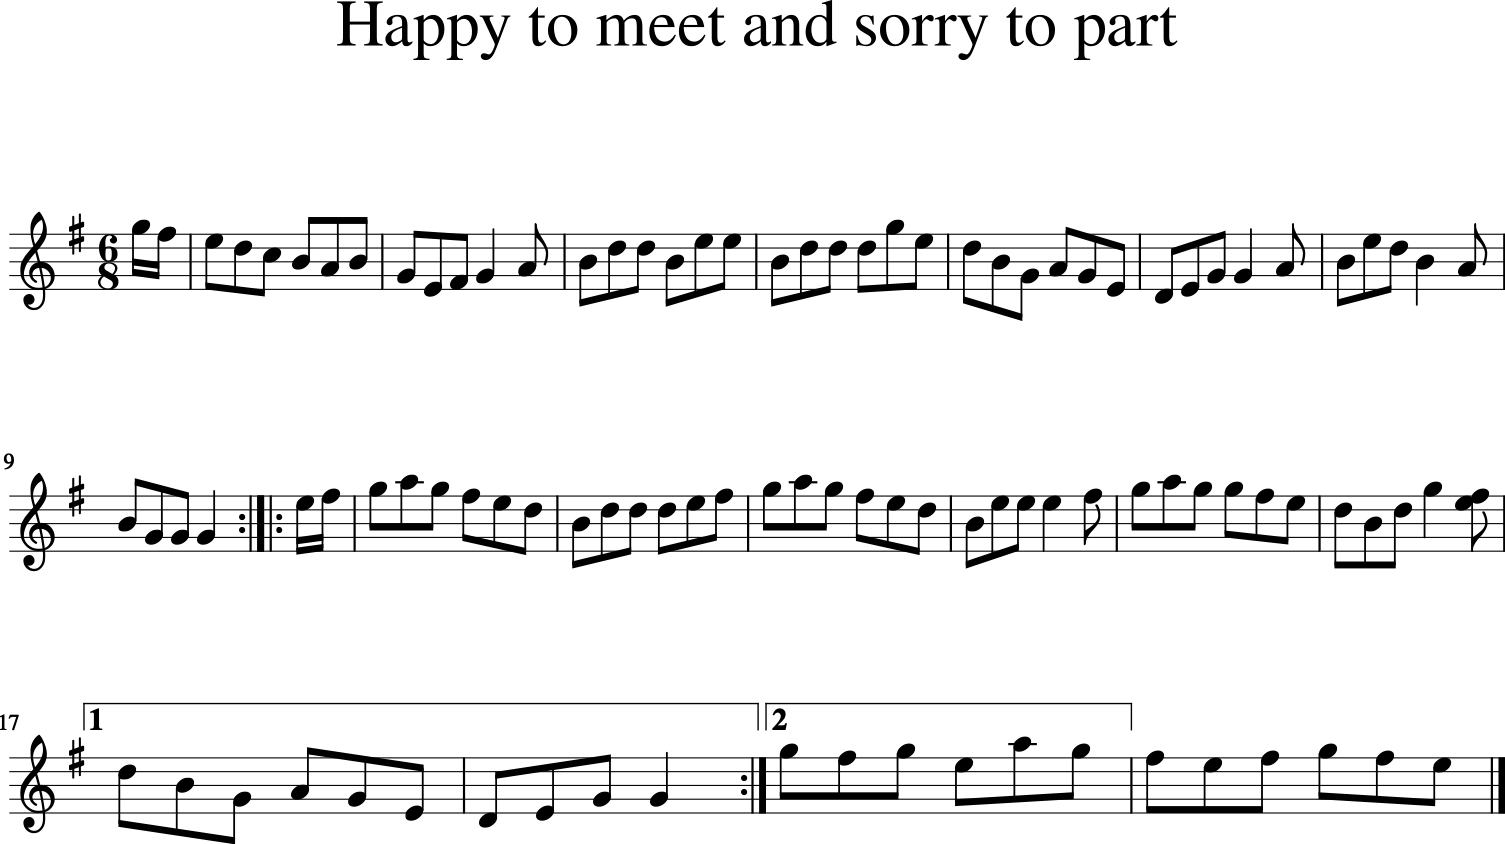




 ... 



In [35]:
for query, exceptions in weird_tunes.items():
    count = len(exceptions)
    print(f"\n\n{10*'='} Exceptions contiaining '{query}' ({count}) {10*'='}\n")
    max_print = 1
    for (idx, _) in exceptions[:max_print]:
        abc = parsed_abc[idx]
        for k, v in abc.items():
            print(f"{k}: {v}")
        print("\n")
        oneills_opus.scores[idx].show()
        print("\n")
    if count > max_print:
        print("\n ... \n")
        
        

# Extra: music21 built-in plots

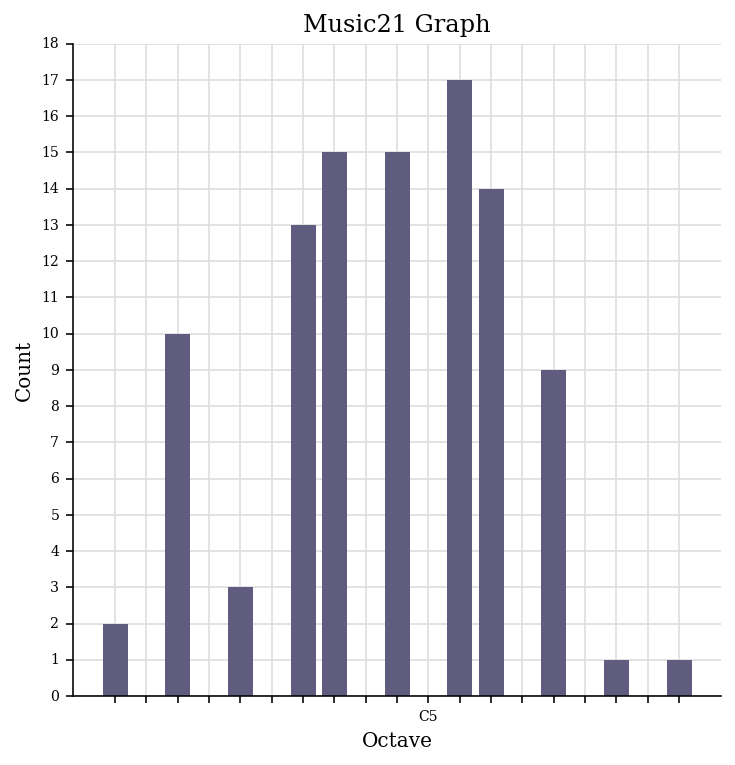

In [36]:
score.plot('histogram', 'octave', xHideUnused=False)

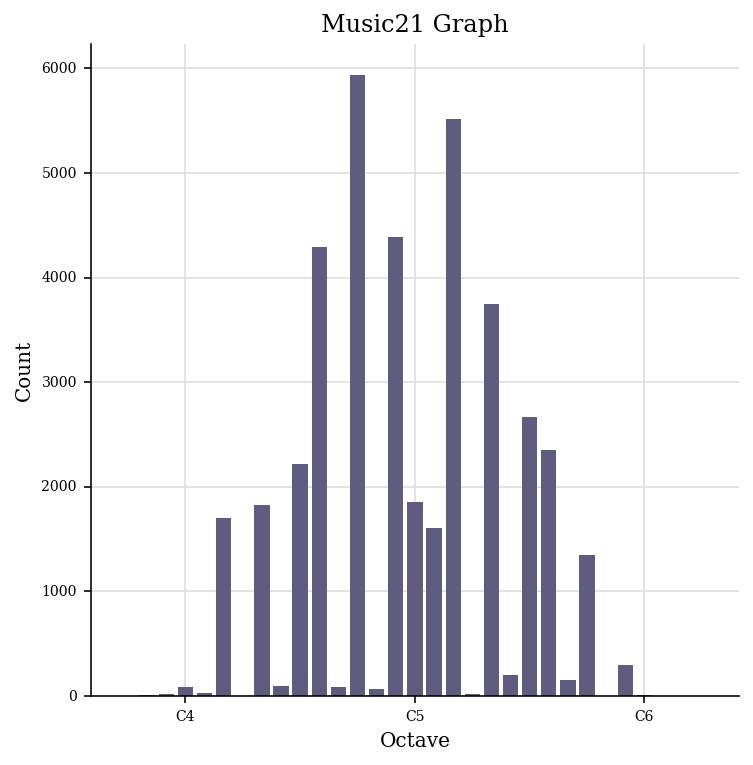

In [37]:
oneills_opus.plot('histogram', 'octave')

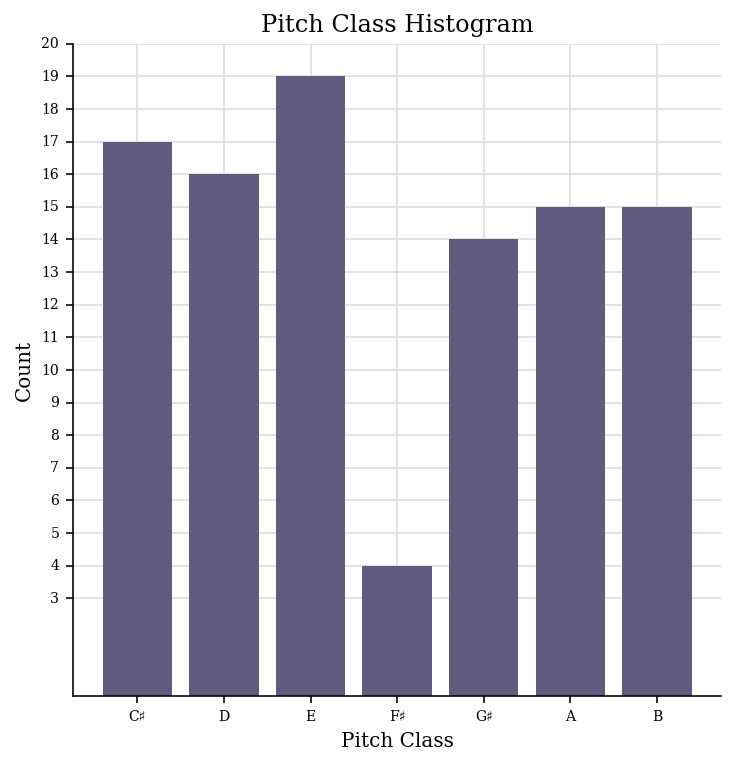

In [38]:
score.plot('histogram', 'pitchClass')

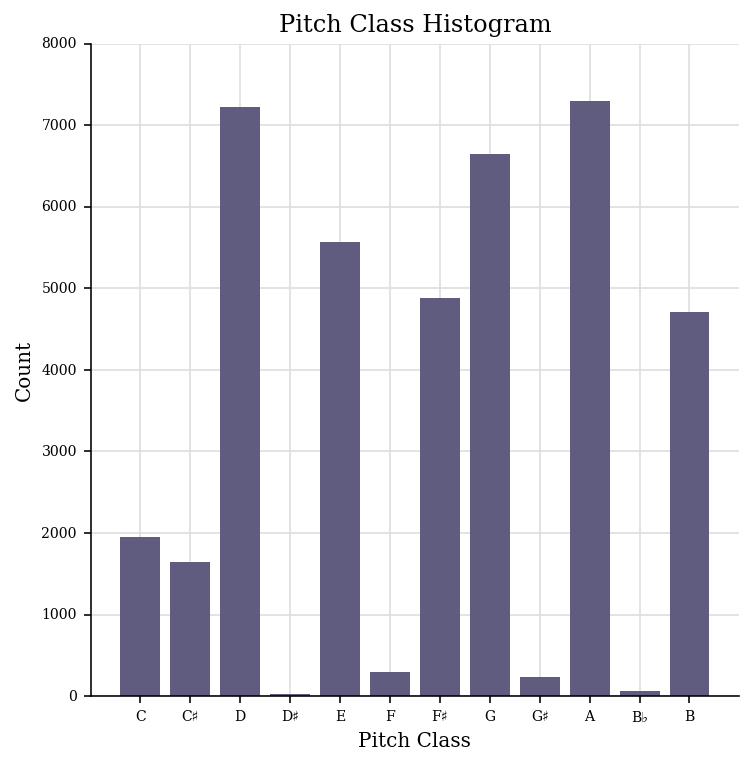

In [39]:
oneills_opus.plot('histogram', 'pitchClass')

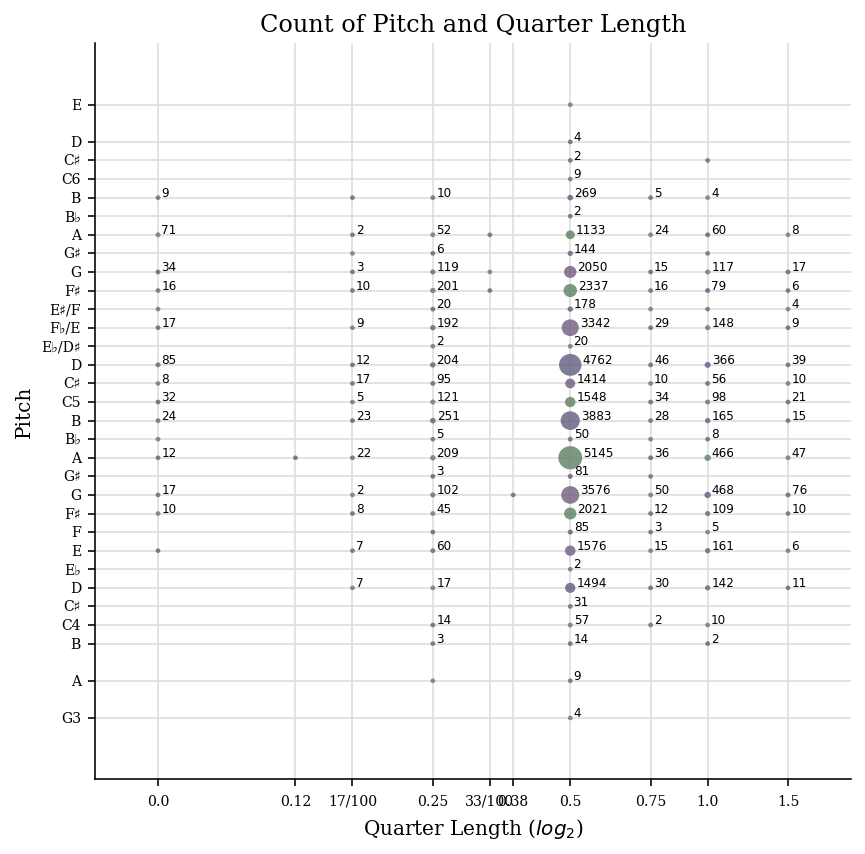

In [40]:
oneills_opus.plot('scatterweighted', 'pitch', 'quarterLength')

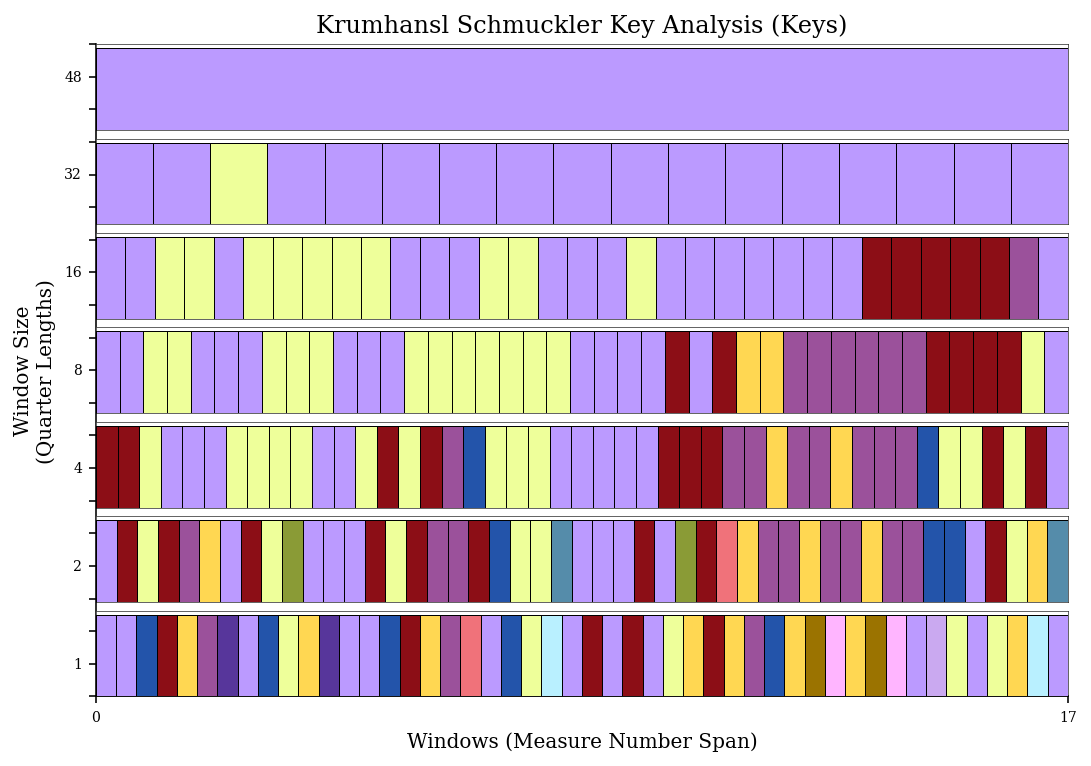

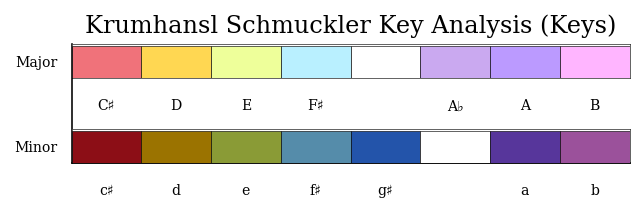

In [41]:
p = music21.graph.plot.WindowedKey(score)
p.run()